In [1]:
%load_ext autoreload
%autoreload 2
USER = %env USER

In [2]:
#from fpipe.plot import plot_waterfall as pw
#from fpipe.container.timestream import FAST_Timestream
from fpipe.timestream import data_format
from fpipe.point_source import source
from fpipe.utils import coord
from fpipe.timestream import rm_baseline

import numpy as np
from numpy.lib.recfunctions import merge_arrays
import gc

from scipy.ndimage import median_filter, gaussian_filter
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import h5py
import healpy as hp

In [3]:
b_G = lambda r, sigma: np.exp(-0.5 * r**2/sigma**2)

#J.G.Mangum et. al. A&A 474, 679–687 (2007) DOI: 10.1051/0004-6361:20077811
#Bessel * Gaussian
beam_model = b_G

In [4]:
def isolate_source(nvss_ra, nvss_dec, nvss_flx, nvss_name, threshold=2.):

    r = np.sin(np.radians(nvss_dec[:, None])) * np.sin(np.radians(nvss_dec[None, :])) \
      + np.cos(np.radians(nvss_dec[:, None])) * np.cos(np.radians(nvss_dec[None, :])) \
      * np.cos(np.radians( nvss_ra[:, None])  - np.radians(nvss_ra[None, :]))
    r[r>1] = 1.
    r = np.rad2deg(np.arccos(r))
    r[r==0] = 1000
    bad = r < threshold/60.
    
    n_cat = nvss_ra.shape[0]
    bad = np.any(bad, axis=0)
    nvss_ra   = nvss_ra[~bad]
    nvss_dec  = nvss_dec[~bad]
    nvss_flx  = nvss_flx[~bad]
    nvss_name = nvss_name[~bad]
    
    print '%d of %d sources left with threshold cut %f arcmin'%(nvss_ra.shape[0], n_cat, threshold)
    
    del r
    gc.collect()
    
    return nvss_ra, nvss_dec, nvss_flx, nvss_name

def load_catalogue(nvss_path_list, nvss_range, flux_key, name_key, flux_lim=10, threshold=0):
    
    nvss_ra, nvss_dec, nvss_flx, nvss_name = [], [], [], []
    for nvss_path in nvss_path_list:
        nvss_cat = source.get_nvss_radec(nvss_path, nvss_range)
        #print nvss_cat['RA'].min(), nvss_cat['RA'].max()

        nvss_sel = nvss_cat[flux_key] > flux_lim
        nvss_ra.append(nvss_cat['RA'][nvss_sel])
        nvss_dec.append(nvss_cat['DEC'][nvss_sel])
        nvss_flx.append(nvss_cat[flux_key][nvss_sel])
        nvss_name.append(nvss_cat[name_key][nvss_sel])

        del nvss_cat
        gc.collect()

    nvss_ra = np.concatenate(nvss_ra, axis=0)
    nvss_dec = np.concatenate(nvss_dec, axis=0)
    nvss_flx = np.concatenate(nvss_flx, axis=0)
    nvss_name = np.concatenate(nvss_name, axis=0)
    
    ## remove redundancy according to name
    nvss_name, redu = np.unique(nvss_name, return_index=True)
    nvss_ra  = nvss_ra[redu]
    nvss_dec = nvss_dec[redu]
    nvss_flx = nvss_flx[redu]
    
    if threshold > 0:
        return isolate_source(nvss_ra, nvss_dec, nvss_flx, nvss_name, threshold=threshold)
    
    return nvss_ra, nvss_dec, nvss_flx, nvss_name

def find_nvss_properly_scanned(fdata, nvss_cat, fwhm_path='', beam_list = None, threshold=3):
    
    vis  = fdata.data
    time = fdata.time
    freq = fdata.freq
    #print freq[0], freq[-1], freq.shape[0]
    mask = fdata.mask
    ns_on= fdata.ns_on
    vis = np.ma.array(vis, mask=mask)
    #vis.mask += vis == 0
    vis.mask += ns_on[:, None, None, :]
    ra, dec = fdata.ra, fdata.dec

    nvss_ra, nvss_dec, nvss_flx, nvss_name = nvss_cat
    if beam_list is None:
        beam_list = fdata.ants
    
    fwhm_data = np.loadtxt(fwhm_path)
    f = fwhm_data[4:, 0 ]
    d = fwhm_data[4:, 1:]
    fwhm = interp1d(f, d, axis=0, fill_value="extrapolate")
    sigma = np.mean(fwhm(freq), axis=0) / 2. / (2.*np.log(2.))**0.5
    
    nvss_ra  = nvss_ra[None, :]
    nvss_dec = nvss_dec[None, :]
    
    for beam in beam_list:
        
        i = beam - 1
        
        _ra = ra[:, i][:, None]
        _dec= dec[:, i][:, None]

        r = np.sin(np.radians(_dec)) * np.sin(np.radians(nvss_dec)) \
          + np.cos(np.radians(_dec)) * np.cos(np.radians(nvss_dec)) \
          * np.cos(np.radians(_ra) - np.radians(nvss_ra))
        r[r>1] = 1.
        r = np.arccos(r) 
        
        p = ( np.sin(r) * np.cos(np.radians(_dec)))
        p[p==0] = np.inf
        p = ( np.sin(np.radians(nvss_dec)) - np.cos(r) * np.sin(np.radians(_dec)) ) / p
        #print p.max(), p.min()
        p[p>1] = 1.
        p = np.arccos(p) * np.sign(_ra - nvss_ra)
        
        r *= 180./np.pi * 60. # arcmin
        p *= 180./np.pi * 60. # arcmin
        
        t_where, nvss_where = np.where(r<threshold)
        nvss_on = np.unique(nvss_where)
        for nvss_idx in nvss_on:
            t_sel_c = np.median(t_where[nvss_where==nvss_idx])
            t_sel_c = int(t_sel_c)
            t_sel = np.arange(t_sel_c-50, t_sel_c+50)
            
            t_sel = t_sel[t_sel>0]
            t_sel = t_sel[t_sel<r.shape[0]]
            t_sel = list(t_sel)

            # only one nvss source in the field of view
            #rr = r[t_sel, nvss_idx]
            #rr_min = rr.min()
            #aa = np.exp(-0.5 * rr**2/sigma[i]**2) * nvss_flx[nvss_idx]
            
            # all nvss sources
            rr = r[t_sel, :]
            pp = p[t_sel, :]
            #print pp[:, nvss_idx].min(), pp[:, nvss_idx].max(), pp[0, nvss_idx], pp[-1, nvss_idx]
            rr_min = rr.min()
            aa = np.sum(beam_model(rr, sigma[i]) * nvss_flx, axis=1)
            
            xx = time[t_sel]
            xx0 = xx[0]

            yy = vis[t_sel, :, :, i] / source.mJy2K(freq*1.e-3)[None, :, None]
            yy = np.ma.mean(yy, axis=1)
            
            yield beam, nvss_name[nvss_idx], nvss_flx[nvss_idx], \
                  nvss_ra[0, nvss_idx], nvss_dec[0, nvss_idx], aa, xx, yy, \
                  rr[:, nvss_idx], pp[:, nvss_idx]

In [5]:
def make_beam(file_list, beam=1, flux_weight=True, model=False):
    BEAM = 'B%02d/'%beam
    
    N = 50
    bin_xx = np.linspace(-6, 6, N + 1)
    bin_yy = np.linspace(-6, 6, N + 1)
    
    beam2d = np.zeros((N, N))
    norm2d = np.zeros((N, N))
    
    for file in file_list:
        with h5py.File(file, 'r') as f:
            s_list = f[BEAM].keys()
            for s in s_list:
                beam_dist = f[BEAM + s + '/BEAM_DIST'][:]
                beam_angl = f[BEAM + s + '/BEAM_ANGL'][:] / 60. * np.pi / 180.
                nvss_flux = f[BEAM + s + '/FLUXRADEC'][0] 
                xx  = beam_dist * np.sin(beam_angl)
                yy  = beam_dist * np.cos(beam_angl)
                if model:
                    zz = f[BEAM + s + '/NVSS_FLUX'][:]
                else:
                    zz = f[BEAM + s + '/FAST_FLUX'][:, 0]
                #zz /= nvss_flux
                ww  = np.ones_like(beam_dist)
                if flux_weight:
                    ww = ww * nvss_flux
                else:
                    zz /= nvss_flux
                norm = np.histogram2d(xx, yy, bins = (bin_xx, bin_yy), weights=ww)[0] * 1.
                hist = np.histogram2d(xx, yy, bins = (bin_xx, bin_yy), weights=zz)[0] * 1.

                beam2d += hist
                norm2d += norm
                
    norm2d[norm2d==0] = np.inf
    beam2d /= norm2d
    
    return beam2d, bin_xx, bin_yy


In [6]:
def output_source(file_root, file_name_list, output_path, nvss_path_list, 
                  fwhm_path='', flux_key='FLUX_20_CM', name_key='NAME', iso_threshold=0):

    for file_name in file_name_list:
        file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i)
                     for i in range(1, 8)]
        output_name = file_name.replace('/', '_')
        
        fdata = data_format.FASTh5_Spec(file_list, fmin=3000, fmax=4500)
        
        ra, dec = fdata.ra, fdata.dec
        nvss_range = [[ra.min(), ra.max(), dec.min(), dec.max()],]
        print nvss_range
        nvss_cat = load_catalogue(nvss_path_list, nvss_range, flux_key, name_key, threshold=iso_threshold)

        with h5py.File(output_path + output_name + '.h5', 'w') as f:
            print output_name
            for xx in find_nvss_properly_scanned(fdata, nvss_cat, fwhm_path, threshold=3):
                beam      = xx[0]
                nvss_name = xx[1]
                if isinstance(nvss_name, str):
                    nvss_name = nvss_name.replace(' ', '_')
                elif isinstance(nvss_name, int):
                    nvss_name = 'NVSSID_%d'%nvss_name
                #print 'Beam %02d %s'%(beam, nvss_name)
                f['B%02d/%s/NVSS_FLUX'%(beam, nvss_name)] = xx[5]
                f['B%02d/%s/TIME_STEP'%(beam, nvss_name)] = xx[6]
                f['B%02d/%s/FAST_FLUX'%(beam, nvss_name)] = xx[7]
                f['B%02d/%s/BEAM_DIST'%(beam, nvss_name)] = xx[8]
                f['B%02d/%s/BEAM_ANGL'%(beam, nvss_name)] = xx[9]
                f['B%02d/%s/FLUXRADEC'%(beam, nvss_name)] = (xx[2], xx[3], xx[4])
        print


In [7]:
def project_nvss_to_map_partial(nside, pixs, nvss_path_list, nvss_range, flux_key='FLUX_20_CM', 
                                name_key='NAME', flux_lim=500, fwhm_path=None):

    if fwhm_path is not None:
        data = np.loadtxt(fwhm_path)
        f = data[4:, 0] #* 1.e-3
        d = data[4:, 1:]
        fwhm = interp1d(f, np.mean(d, axis=1), fill_value="extrapolate")(1400)
        fwhm /= 60.
        sig = fwhm / 2. / np.sqrt(2. * np.log(2.))

    pix_size = hp.nside2resol(nside, arcmin=True) / 60.

    pixs_ra, pixs_dec = hp.pix2ang(nside, pixs, lonlat=True)

    pixs_ra  = pixs_ra.astype('float64')
    pixs_dec = pixs_dec.astype('float64')

    pixs_ra = np.deg2rad(pixs_ra[:, None])
    pixs_dec = np.deg2rad(pixs_dec[:, None])

    nvss_cat = load_catalogue(nvss_path_list, nvss_range, flux_key, name_key, flux_lim)
    #nvss_cat = get_nvss_radec(nvss_path, nvss_range)
    nvss_ra, nvss_dec, nvss_flux, nvss_name = nvss_cat
    nvss_ra = np.deg2rad(nvss_ra[None, :].astype('float64'))
    nvss_dec = np.deg2rad(nvss_dec[None, :].astype('float64'))
    nvss_flux = nvss_flux[None, :]

    nvss_map = np.zeros(pixs.shape, dtype='float64')

    step = 20
    nvss_N = nvss_flux.shape[1]
    for i in range(0, nvss_N, step):
        P = ( np.sin(pixs_dec) * np.sin(nvss_dec[:, i:i+step]) )\
          + ( np.cos(pixs_dec) * np.cos(nvss_dec[:, i:i+step]) )\
          * ( np.cos(pixs_ra - nvss_ra[:, i:i+step]) )
        P[P>1] = 1.
        P = np.rad2deg(np.arccos(P))
        if fwhm_path is not None:
            P = np.exp( - 0.5 * ( P / sig ) ** 2. )
            #P *= 1. / (2. * np.pi * sig ** 2.)
            #P /= np.max(P, axis=0)[None, :]
        else:
            on = P<0.5*pix_size
            P[on] = 1.
            P[~on] = 0.
        P *= nvss_flux[:, i:i+step]
        P = np.sum(P, axis=1)

        nvss_map = nvss_map + P

        del P
        gc.collect()

    return nvss_map, pixs, nside

def make_nvss_map(nvss_path_list, nvss_range, map_range, nside=1024,
                  flux_key='FLUX_20_CM', name_key='NAME', output_path='', 
                  flux_lim=10, fwhm_path=None):

    ra_min, ra_max, dec_min, dec_max = map_range
    v1 = hp.ang2vec(np.pi/2 - np.radians(dec_min), np.radians(ra_min))
    v2 = hp.ang2vec(np.pi/2 - np.radians(dec_min), np.radians(ra_max))
    v3 = hp.ang2vec(np.pi/2 - np.radians(dec_max), np.radians(ra_max))
    v4 = hp.ang2vec(np.pi/2 - np.radians(dec_max), np.radians(ra_min))
    pixs = hp.query_polygon(nside, np.array([v1, v2, v3, v4]))
        
    nvss_map = project_nvss_to_map_partial(nside, pixs, nvss_path_list, nvss_range, 
                                           flux_key=flux_key, name_key=name_key,
                                           flux_lim=flux_lim, fwhm_path=fwhm_path)[0]
    suffix = '_th%d_nside%d'%(flux_lim, nside)
    if fwhm_path is not None:
        suffix += '_beam'
    with h5py.File(output_path + 'firstnvss_map%s.h5'%(suffix), 'w') as f:
        f['clean_map'] = nvss_map
        f['map_pix'] = pixs
        f['nside'] = nside

In [8]:
def sub_bsline(fdata, baseline_file):

    _t = fdata.time.data
    
    for i in range(fdata.data.shape[-1])[:1]:
        #_vis = np.ma.array(fdata.data[...,i], mask=fdata.mask[...,i])
        _vis = fdata.data[...,i]
        _msk = fdata.mask[...,i]
        _vis = np.ma.array(_vis, mask=_msk)
        on = fdata.ns_on[:, i]
        #_vis.mask += on[:, None, None]
        
        bsl = rm_baseline.fit_baseline(_vis[~on], _t[~on], _msk[~on], 
                                       baseline_file)
    
        print bsl[:5, 0, :]
        fdata.data[~on, :, :, i] = bsl
        print fdata.data[:5, 0, :, 0]
    
    _vis = np.ma.array(fdata.data, mask=fdata.mask)
    _vis.mask += fdata.ns_on[:, None, None, :]
    
    fdata.data -= np.ma.median(_vis, axis=0)[None, ...]
    del _vis
    gc.collect()

In [9]:
def check_flux(file_list, nvss_path_list, beam_list=None,
               fwhm_path='', flux_key='FLUX_20_CM', name_key='NAME', fmin=3000, fmax=4500,
               sub_mean=True, baseline_file=None):
    
    fdata = data_format.FASTh5_Spec(file_list, fmin=fmin, fmax=fmax)
    #print fdata.data[:10, 50, :, 0]
    print fdata.freq.min(), fdata.freq.max()
    
    if baseline_file is not None:
        sub_bsline(fdata, baseline_file)
    
    ra, dec = fdata.ra, fdata.dec
    nvss_range = [[ra.min(), ra.max(), dec.min(), dec.max()],]
    #print nvss_range
    nvss_cat = load_catalogue(nvss_path_list, nvss_range, flux_key, name_key)

    for oo in find_nvss_properly_scanned(fdata, nvss_cat, fwhm_path, beam_list, threshold=0.5):
        beam, nvss_name, nvss_flx, nvss_ra, nvss_dec, aa, xx, yy, rr, pp = oo
        
        fig = plt.figure(figsize=(6, 2))
        ax  = fig.add_axes([0.1, 0.1, 0.9, 0.9])
        
        yy = np.ma.sum(yy, axis=1)/2.
        if sub_mean:
            yy -= np.median(yy)
        ax.plot(xx - xx[0], yy, '.-')
        
        rr_min = rr.min()
        label='%6.4f arcmin to Beam %02d'%(rr_min, beam)
        title = '%s\n %6.4f mJy'%(nvss_name, nvss_flx)
            
        ax.plot(xx - xx[0], aa, 'r', label=label)
        ax.legend(title = title, loc=1)
        #ax.set_ylim(ymin=1.e-1)
        #ax.semilogy()

        plt.show()
        plt.close(fig)

In [16]:
nvss_path = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

nvss_range = [[8.9*15, 13.1*15, 22., 28.0],]
nvss_ra, nvss_dec, nvss_flx, nvss_name = load_catalogue(nvss_path, nvss_range, flux_key, name_key, flux_lim=10)


1323.26 1449.9738


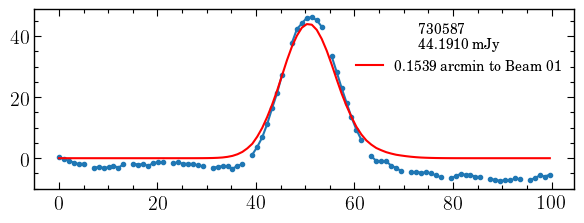

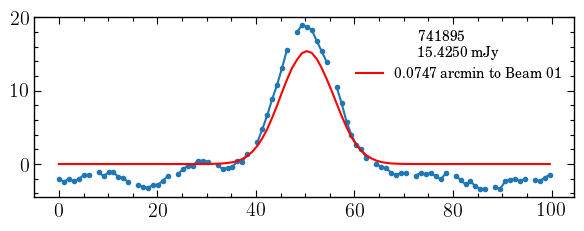

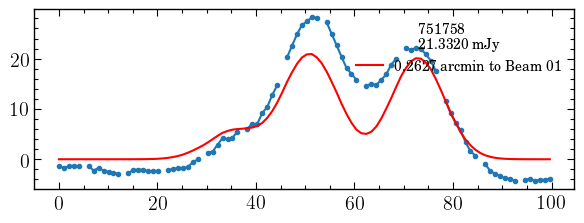

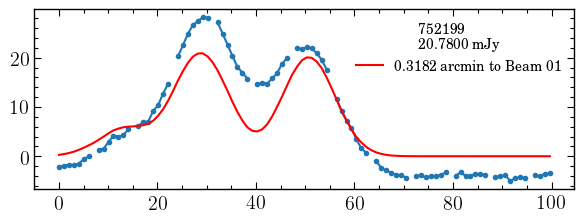

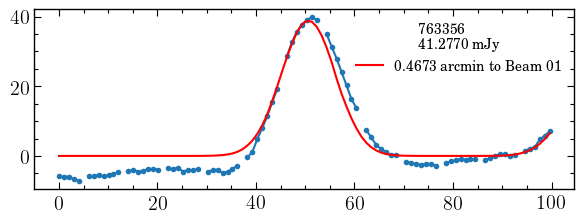

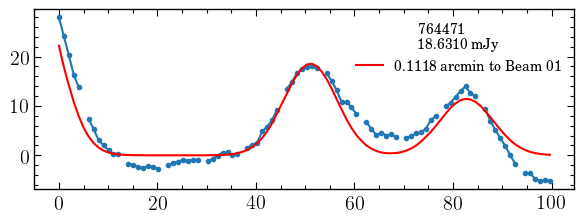

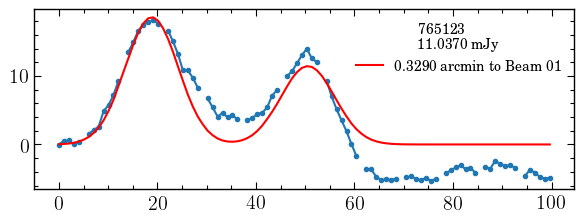

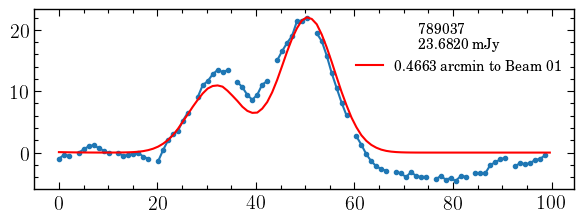

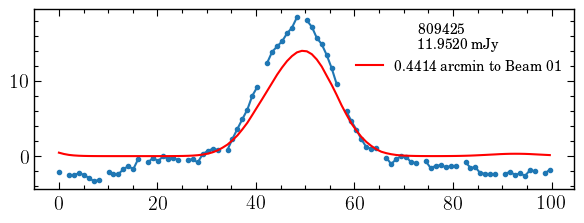

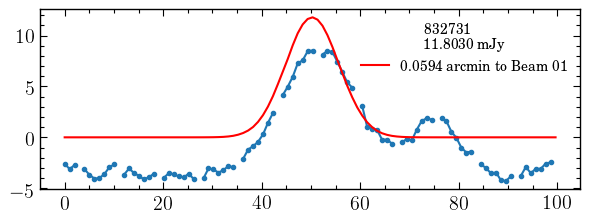

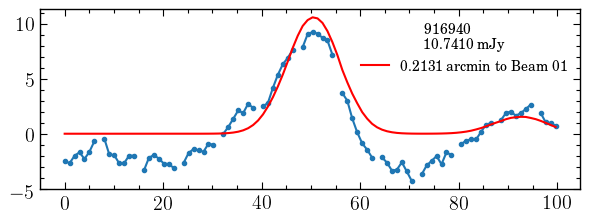

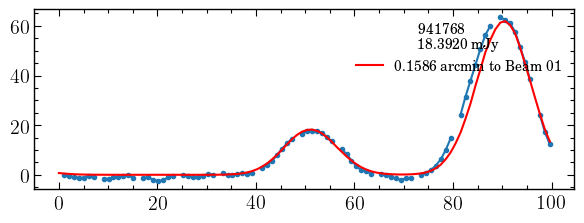

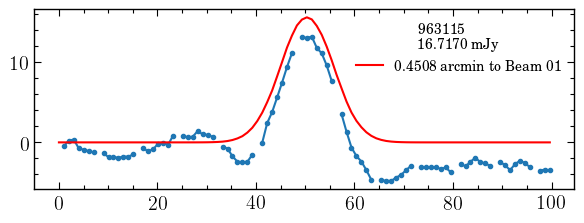

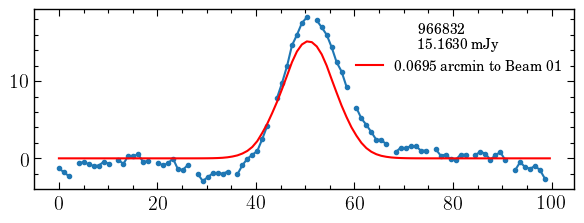

In [12]:
nvss_path = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

#name_key = 'UNIQ_ID'
#flux_key = 'GB6_FLUX'
#name_key = 'GB6_ID'

#flux_key = 'FIRST_FLUX'
#name_key = 'FIRST_ID'


#nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
#flux_key = 'FLUX_20_CM'
#name_key = 'NAME'

fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_etaA_sumfeeds/'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds/'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_etaA_sumfeeds_CC/'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC2/'
file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name = '20210302/HIMGS_1100+2600'
#file_name = '20210314/HIMGS_1100+2610'
#file_name = '20210305/HIMGS_1100+2632'
file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
             for i in range(1, 8)]

baseline_file = None
#baseline_file = '/idia/users/ycli/fdata/baseline/HIMGS_1100+2610_20210314.h5'
#baseline_file = '/idia/users/ycli/fdata/baseline/HIMGS_1100+2600_20210302.h5'

check_flux(file_list, nvss_path, beam_list = [1, ], 
           fwhm_path=fwhm_path, flux_key=flux_key, name_key=name_key,
           #fmin=2500, fmax=3500, 
           fmin=0, fmax=None, 
           sub_mean=False, baseline_file=baseline_file)

In [13]:
nvss_path = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'
nvss_range = [[9*15, 13*15, 25.8, 27.5],]

fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'

map_name = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/Combined_1250-1450MHz.h5'
output_path = '/scratch3/users/ycli/fanalysis/'

map_range = [9*15, 13*15, 22., 28.0]
#nside = 4096
nside = 2048
make_nvss_map(nvss_path, nvss_range, map_range=map_range, nside=nside, 
              flux_key=flux_key, name_key=name_key, output_path=output_path, 
              flux_lim=1, fwhm_path=fwhm_path)

In [12]:
nvss_path_list = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'

file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name_list = [#'20210314/HIMGS_1100+2610',
                  '20210302/HIMGS_1100+2600', '20210305/HIMGS_1100+2632', 
                  '20210306/HIMGS_1100+2643', '20210307/HIMGS_1100+2654', 
                  '20210309/HIMGS_1100+2610', #'20210313/HIMGS_1100+2621', 
                  ]

iso_threshold = 5.
output_path = '/scratch3/users/ycli/fanalysis/nvss_tod_iso%d/'%iso_threshold
output_source(file_root, file_name_list, output_path, nvss_path_list, 
              fwhm_path=fwhm_path, flux_key=flux_key, name_key=name_key, iso_threshold=iso_threshold)

[[134.70083040073965, 195.3113744000576, 25.770177327403804, 26.198494767749963]]
214 of 432 sources left with threshold cut 5.000000 arcmin
20210302_HIMGS_1100+2600


/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:97: RuntimeWarning: invalid value encountered in arccos



[[134.69762221550923, 195.3114093996176, 26.316363544887448, 26.7392399350119]]
194 of 354 sources left with threshold cut 5.000000 arcmin
20210305_HIMGS_1100+2632

[[134.69861122373578, 195.31243244715, 26.489811294238628, 26.919515983660865]]
205 of 392 sources left with threshold cut 5.000000 arcmin
20210306_HIMGS_1100+2643

[[134.69750502633025, 195.31288495279142, 26.67060801988521, 27.10219072879798]]
194 of 374 sources left with threshold cut 5.000000 arcmin
20210307_HIMGS_1100+2654

[[134.70445365479753, 189.13723339491932, 25.946011362635904, 26.376124328797466]]
187 of 350 sources left with threshold cut 5.000000 arcmin
20210309_HIMGS_1100+2610



In [ ]:
nvss_path_list = [
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_135RA140.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_140RA145.fits', 
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_145RA150.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_150RA155.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_155RA160.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_160RA165.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_165RA170.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_170RA175.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_180RA185.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_185RA190.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_190RA195.fits',
    '/idia/users/ycli/NVSS/FIRST_NVSS/Complete_195RA200.fits',
]

flux_key = 'NVSS_FLUX'
name_key = 'NVSS_ID'

fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'

file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name_list = [#'20210314/HIMGS_1100+2610',
                  '20210302/HIMGS_1100+2600', '20210305/HIMGS_1100+2632', 
                  '20210306/HIMGS_1100+2643', '20210307/HIMGS_1100+2654', 
                  '20210309/HIMGS_1100+2610', #'20210313/HIMGS_1100+2621', 
                  ]

iso_threshold = 5.
output_path = '/scratch3/users/ycli/fanalysis/nvss_tod_iso%d/'%iso_threshold
output_source(file_root, file_name_list, output_path, nvss_path_list, 
              fwhm_path=fwhm_path, flux_key=flux_key, name_key=name_key, iso_threshold=iso_threshold)

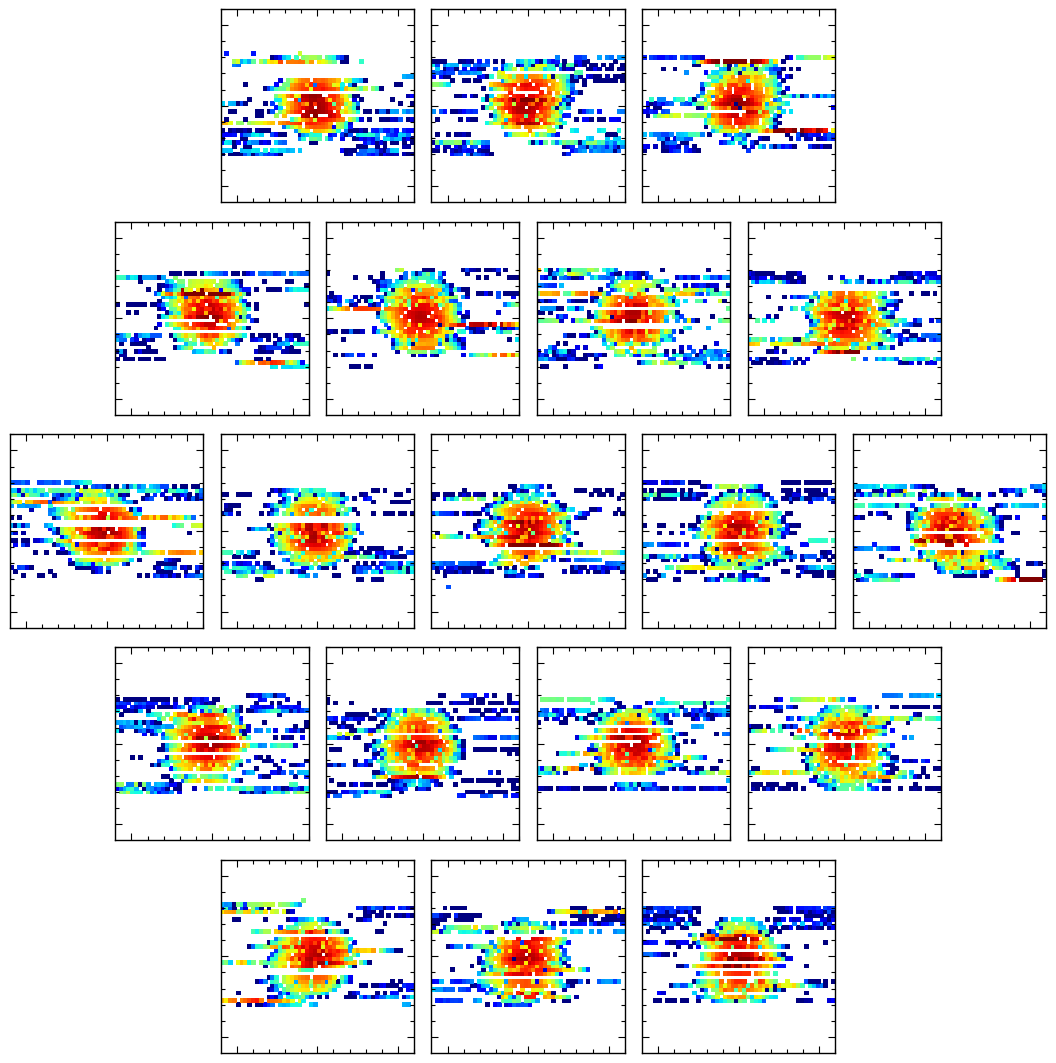

In [26]:
beam_file_list = [
    output_path + '20210302_HIMGS_1100+2600.h5',
    output_path + '20210305_HIMGS_1100+2632.h5',
    output_path + '20210306_HIMGS_1100+2643.h5',
    output_path + '20210307_HIMGS_1100+2654.h5',
    output_path + '20210309_HIMGS_1100+2610.h5',
    #output_path + '20210313_HIMGS_1100+2621.h5',
    output_path + '20210314_HIMGS_1100+2610.h5',
]
fig, axes = coord.beam_axes()
for i in range(19):
    B, xx, yy = make_beam(beam_file_list, beam=i+1)
    baseline0 = np.mean(B, 0)
    baseline1 = np.mean(B, 1)
    B -= ( baseline0[None, :] * baseline1[:, None] ) ** 0.5
    B = np.ma.masked_less_equal(B, 0)
    axes[i].pcolormesh(xx, yy, np.ma.log10(B.T), vmax=0, vmin=-2, cmap='jet')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_aspect('equal')

In [43]:
#    nvss_ra  = nvss_ra[None, :]
#    nvss_dec = nvss_dec[None, :]
#    
#    for i in range(1):
#        
#        _ra = ra[:, i][:, None]
#        _dec= dec[:, i][:, None]
#
#        r = np.sin(np.radians(_dec)) * np.sin(np.radians(nvss_dec)) \
#          + np.cos(np.radians(_dec)) * np.cos(np.radians(nvss_dec)) \
#          * np.cos(np.radians(_ra) - np.radians(nvss_ra))
#        r[r>1] = 1.
#        r = np.arccos(r) * 180./np.pi * 60.
#        
#        t_where, nvss_where = np.where(r<4.)
#        
#        nvss_on = np.unique(nvss_where)
#        #nvss_on = np.unique(np.where(r<4.)[1])
#        for nvss_idx in nvss_on:
#            t_sel_c = np.median(t_where[nvss_where==nvss_idx])
#            t_sel_c = int(t_sel_c)
#            t_sel = np.arange(t_sel_c-50, t_sel_c+50)
#            
#            t_sel = t_sel[t_sel>0]
#            t_sel = list(t_sel)
#
#            #rr = r[t_sel, nvss_idx]
#            #rr_min = rr.min()
#            #aa = np.exp(-0.5 * rr**2/sigma[i]**2) * nvss_flx[nvss_idx]
#            
#            rr = r[t_sel, :]
#            rr_min = rr.min()
#            aa = np.sum(np.exp(-0.5 * rr**2/sigma[i]**2) * nvss_flx, axis=1)
#            
#            xx = time[t_sel]
#            xx0 = xx[0]
#
#            yy = vis[t_sel, :, :, i] / source.mJy2K(freq*1.e-3)[None, :, None]
#            yy = np.ma.mean(yy, axis=1)
            
            fig = plt.figure(figsize=(6, 2))
            ax  = fig.add_axes([0.1, 0.1, 0.9, 0.9])
            
            ax.plot(xx - xx[0], np.ma.sum(yy, axis=1)/2., '.-')
            
            label='%6.4f arcmin to Beam %02d'%(rr_min, i)
            title = '%s\n %6.4f mJy'%(nvss_name[nvss_idx], nvss_flx[nvss_idx])
            
            ax.plot(xx - xx[0], aa, 'r', label=label)
            ax.legend(title = title, loc=1)
            #ax.set_ylim(ymin=1.e-1)
            #ax.semilogy()
            

            ax2   = fig.add_axes([0.13, 0.5, 0.2, 0.4])
            ra_c  = _ra[t_sel_c,  0] #nvss_ra[:,  nvss_idx]
            dec_c = _dec[t_sel_c, 0] #nvss_dec[:, nvss_idx]
            _sel  = ( nvss_ra.flatten() < ra_c + 10./60. ) 
            _sel *= ( nvss_ra.flatten() > ra_c - 10./60. )
            _sel *= ( nvss_dec.flatten() < dec_c + 10./60. ) 
            _sel *= ( nvss_dec.flatten() > dec_c - 10./60. )

            
            ax2.plot( (_ra[t_sel] - ra_c)*60, (_dec[t_sel] - dec_c)*60, 'k--' )
            
            ax2.fill_between((_ra[t_sel, 0]  - ra_c)*60, 
                             (_dec[t_sel, 0] - dec_c)*60 + 1.5, 
                             (_dec[t_sel, 0] - dec_c)*60 - 1.5,
                             color='k', alpha=0.3)
            ax2.fill_between((_ra[t_sel, 0]  - ra_c)*60, 
                             (_dec[t_sel, 0] - dec_c)*60 + 3, 
                             (_dec[t_sel, 0] - dec_c)*60 - 3,
                             color='k', alpha=0.3)
            
            ax2.plot((nvss_ra[:, _sel] - ra_c )*60., 
                     (nvss_dec[:, _sel]- dec_c)*60., 'rx', mfc='none')
            
            ax2.set_xlim(-10, 10)
            ax2.set_ylim(-10, 10)
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            ax2.set_aspect('equal')

            plt.show()
            plt.close(fig)
            
            #return

In [17]:
def check_flux_nvss_map(file_list, nvss_map_path, nvss_path, fwhm_path=''):
    
    vis, time, freq, ra, dec, beam_list = load_ts(file_list, slice(2000, 3000))


    with h5py.File(nvss_map_path, 'r') as f:
        nvss_map = f['clean_map'][:]
        pixs  = f['map_pix'][:]
        nside = f['nside'][()]
        
    fwhm_data = np.loadtxt(fwhm_path)
    f = fwhm_data[4:, 0 ]
    d = fwhm_data[4:, 1:]
    fwhm = interp1d(f, d, axis=0, fill_value="extrapolate")
    sigma = np.mean(fwhm(freq), axis=0) / 2. / (2.*np.log(2.))**0.5
    
    nvss_range = [[ra.min(), ra.max(), dec.min(), dec.max()],]
    nvss_cat = source.get_nvss_radec(nvss_path, nvss_range)
    nvss_sel = nvss_cat['FLUX_20_CM'] > 50.
    nvss_ra  = nvss_cat['RA'][nvss_sel]
    nvss_dec = nvss_cat['DEC'][nvss_sel]
    nvss_flx = nvss_cat['FLUX_20_CM'][nvss_sel]
    nvss_name= nvss_cat['NAME'][nvss_sel]
    
    nvss_ra  = nvss_ra[None, :]
    nvss_dec = nvss_dec[None, :]
    
    map_ra, map_dec = hp.pix2ang(nside, pixs, lonlat=True)
    for i in range(1):
        
        _ra  = ra[:, i]
        _dec = dec[:, i]
        sel  = (_ra  > map_ra.min())  * (_ra  < map_ra.max())
        sel *= (_dec > map_dec.min()) * (_dec < map_dec.max())
        _ra  = _ra[sel][:, None]
        _dec = _dec[sel][:, None]
        _vis = vis[sel, :, 0, i] / source.mJy2K(freq * 1.e-3)[None, :]
        
        r = np.sin(np.radians(_dec)) * np.sin(np.radians(nvss_dec)) \
          + np.cos(np.radians(_dec)) * np.cos(np.radians(nvss_dec)) \
          * np.cos(np.radians(_ra) - np.radians(nvss_ra))
        r[r>1] = 1.
        r = np.arccos(r) * 180./np.pi * 60.
        
        t_where, nvss_where = np.where(r<4.)
        
        nvss_on = np.unique(nvss_where)
        
        for nvss_idx in nvss_on:
            t_sel_c = np.median(t_where[nvss_where==nvss_idx])
            t_sel_c = int(t_sel_c)
            t_sel = np.arange(t_sel_c-50, t_sel_c+50)
            
            t_sel = t_sel[t_sel>0]
            t_sel = list(t_sel)
            
            xx = _ra[t_sel].flatten()
            yy = np.mean(_vis[t_sel, :], axis=1)
        
            fig = plt.figure(figsize=(6, 2))
            ax  = fig.add_axes([0.1, 0.1, 0.9, 0.9])
            
            
            ax.plot(xx, yy, '.-')
            
            #label='%6.4f arcmin to Beam %02d'%(rr_min, i)
            #title = '%s\n %6.4f mJy'%(nvss_name[nvss_idx], nvss_flx[nvss_idx])
            

            #ax.plot(xx, aa, 'r', label=label)
            #ax.legend(title = title, loc=1)
        
        
            tod_pix = hp.ang2pix(nside, _ra[t_sel].flatten(), _dec[t_sel].flatten(), lonlat=True)
        
            tod_idx = [np.where(pixs == x)[0][0] for x in tod_pix]
        
            tod_val = nvss_map[tod_idx]
            ax.plot(xx, tod_val, 'k.-')


1384.296 1414.7849


/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


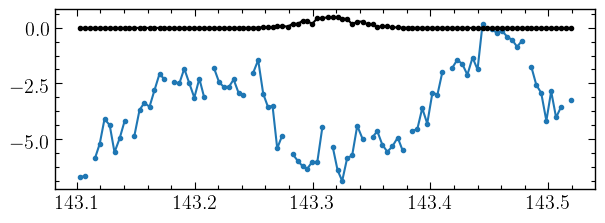

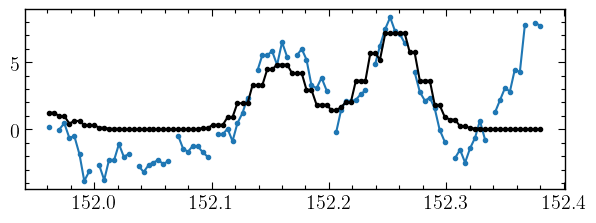

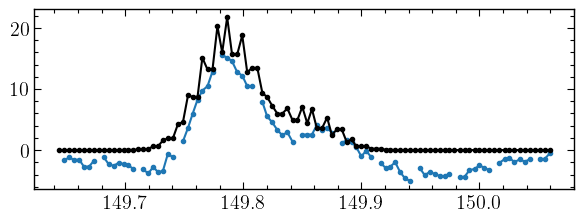

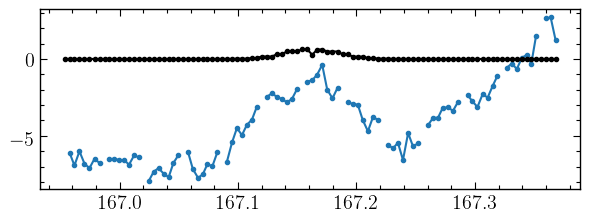

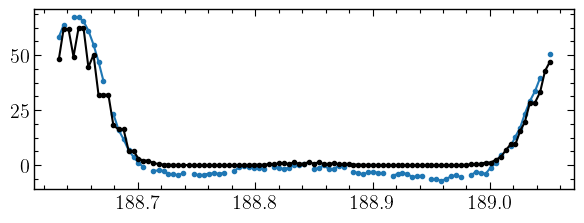

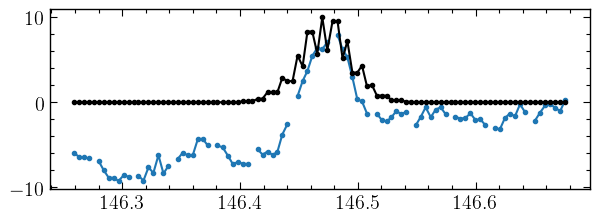

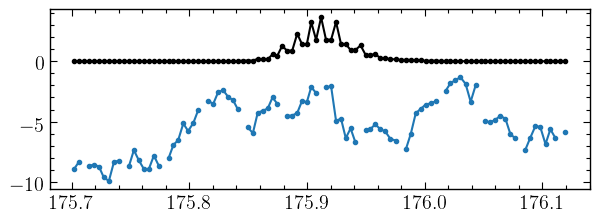

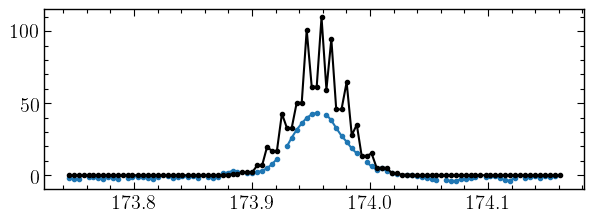

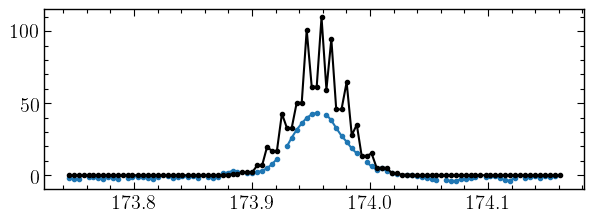

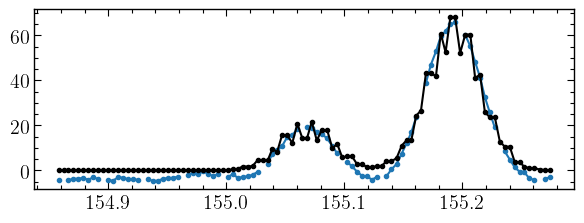

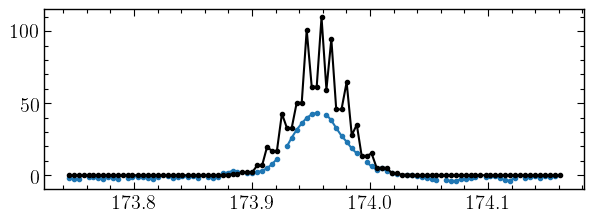

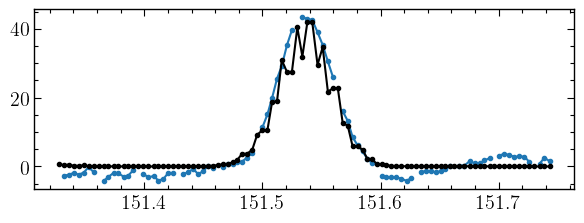

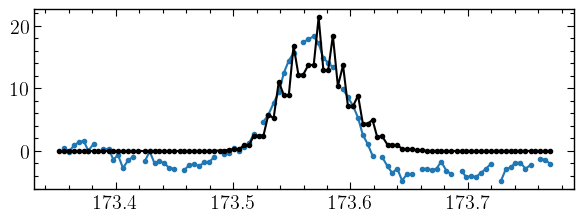

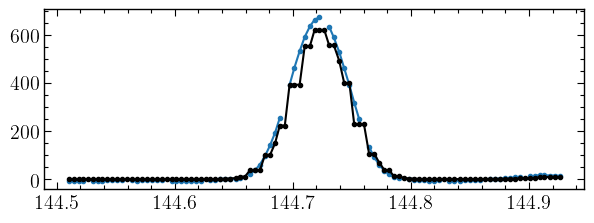

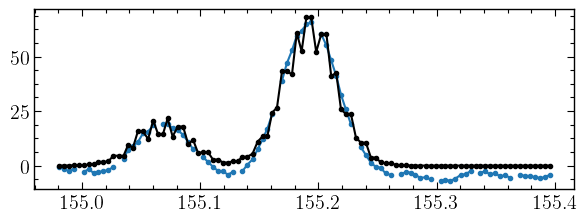

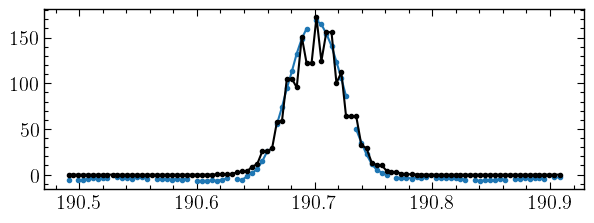

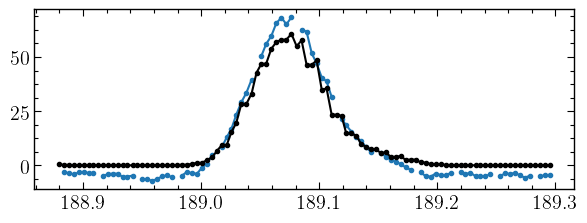

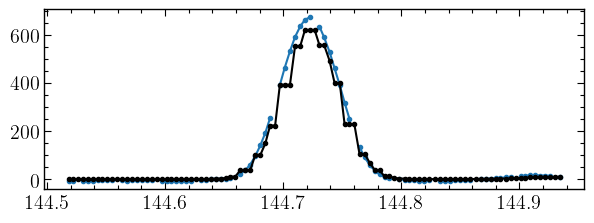

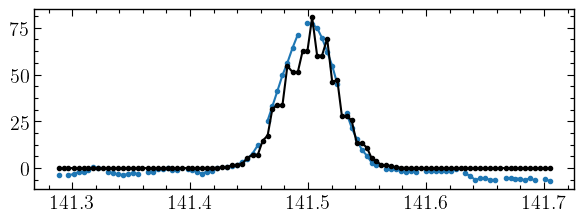

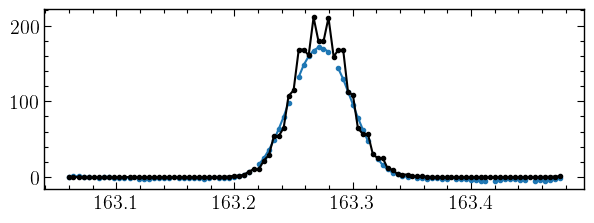

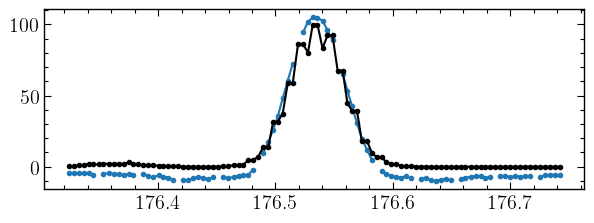

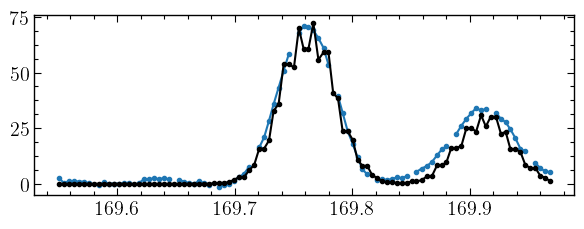

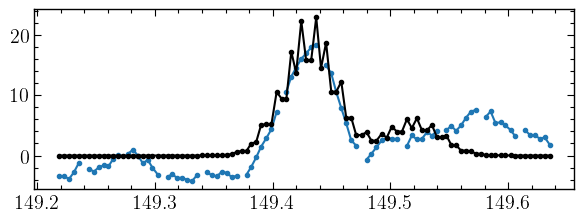

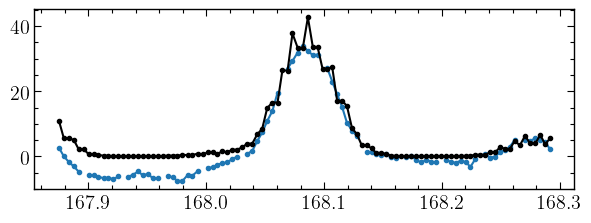

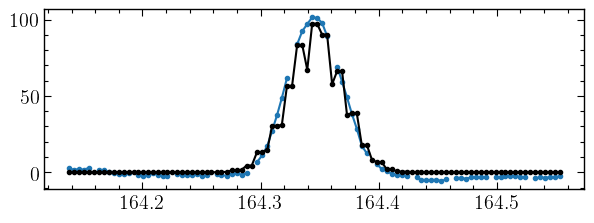

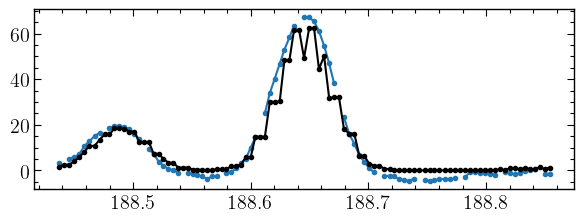

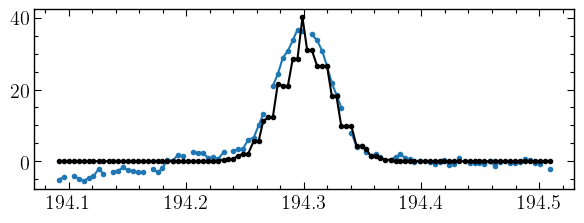

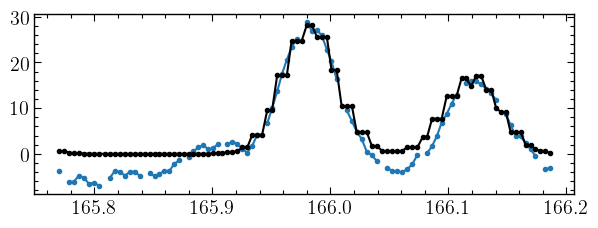

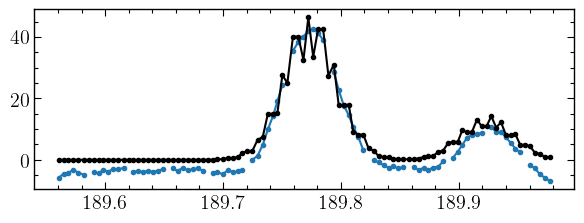

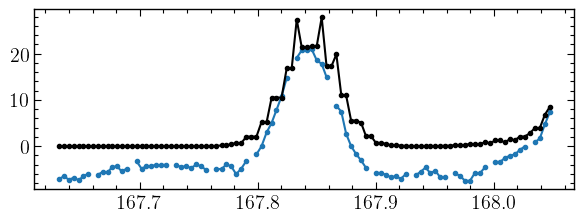

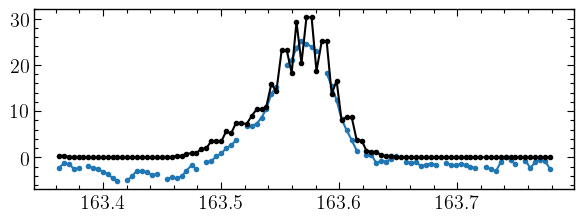

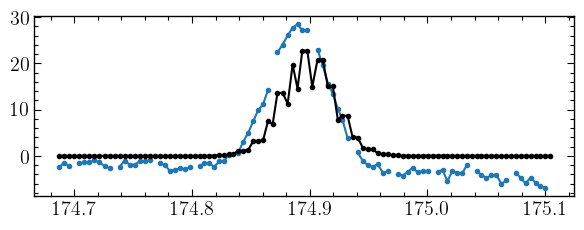

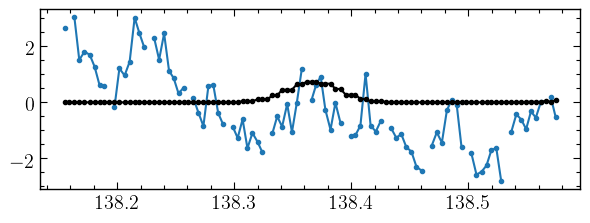

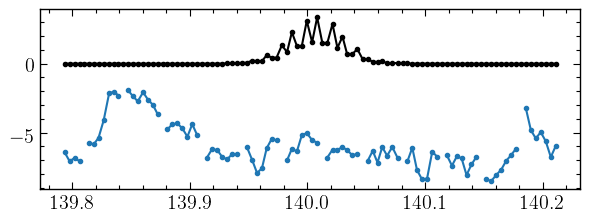

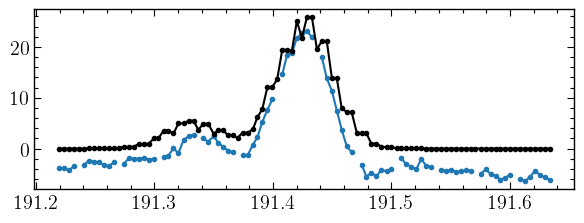

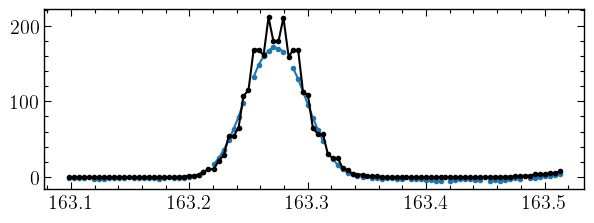

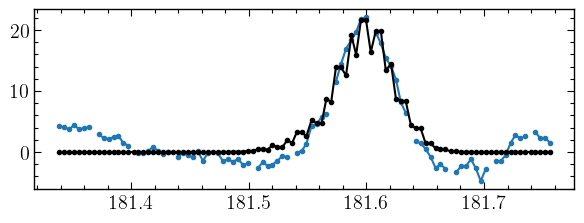

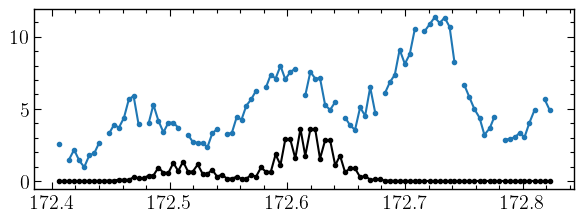

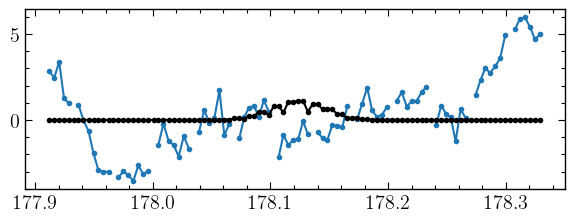

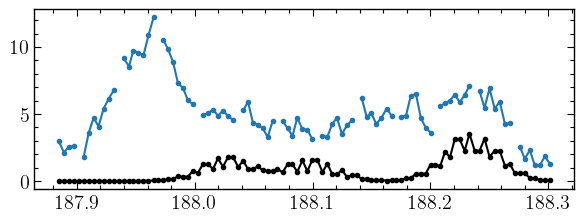

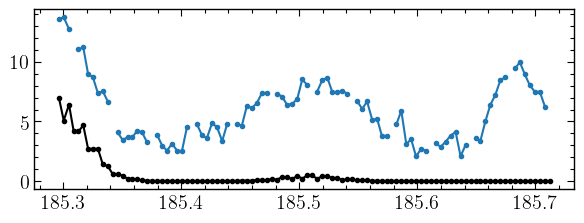

In [7]:
nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'
nvss_map_path = '/scratch3/users/ycli/fanalysis/nvss_map_th10_nside8192_beam.h5'
file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
file_name = '20210302/HIMGS_1100+2600'
file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
             for i in range(1, 8)]
check_flux_nvss_map(file_list, nvss_map_path, nvss_path, fwhm_path)

1384.2975 1414.7856


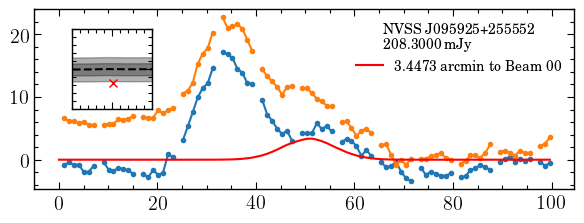

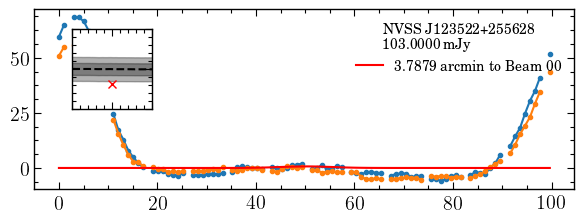

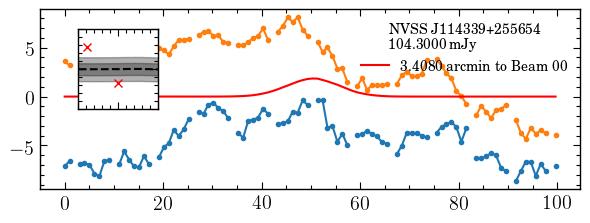

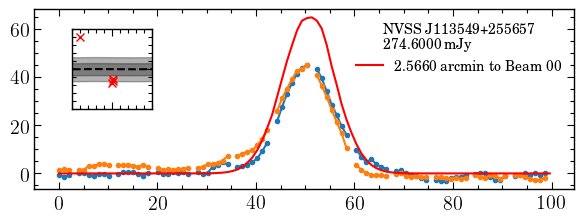

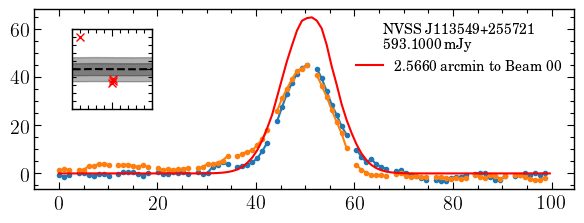

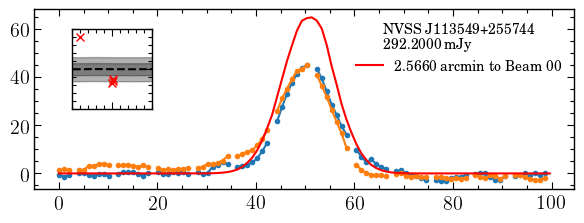

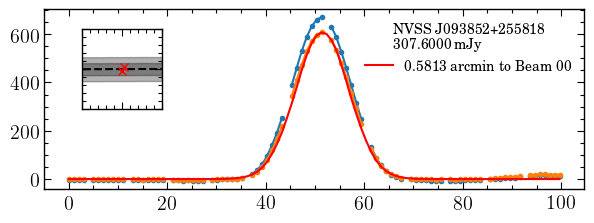

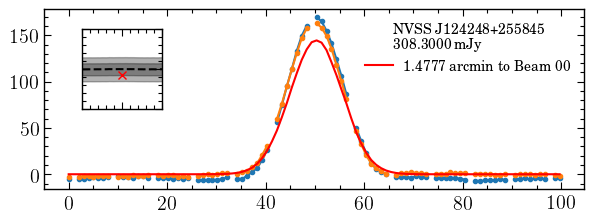

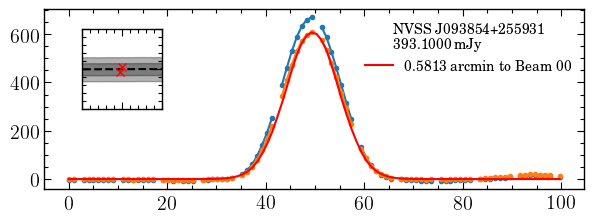

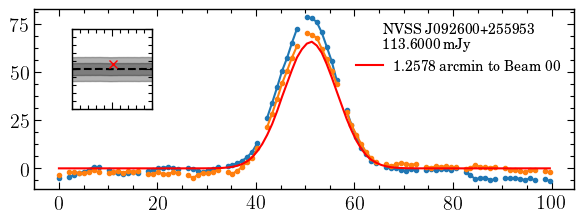

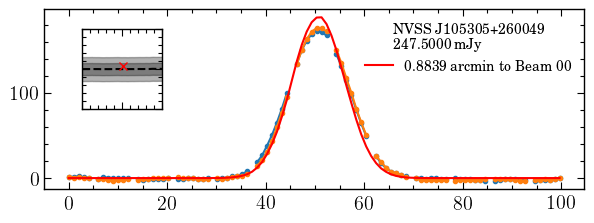

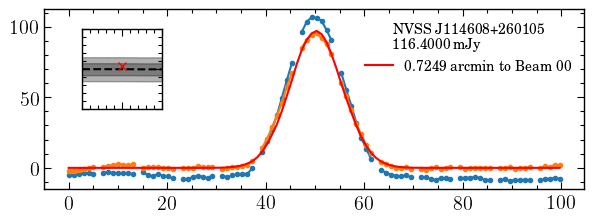

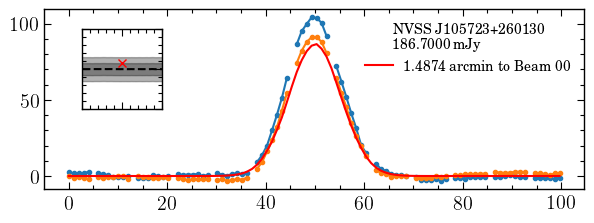

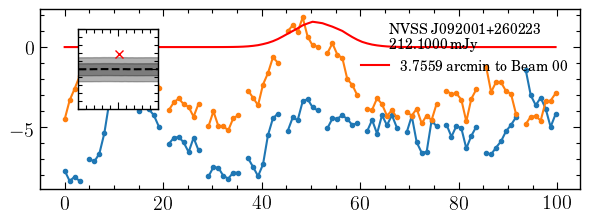

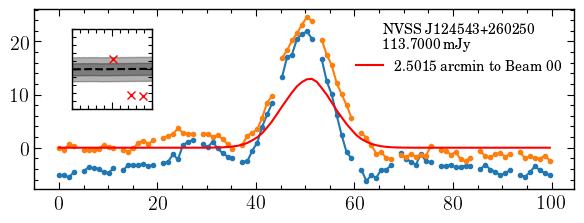

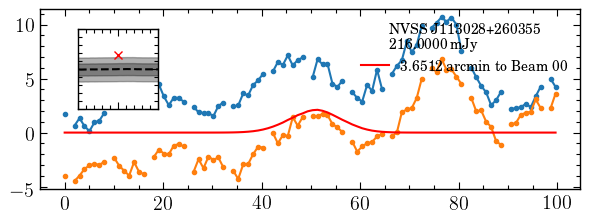

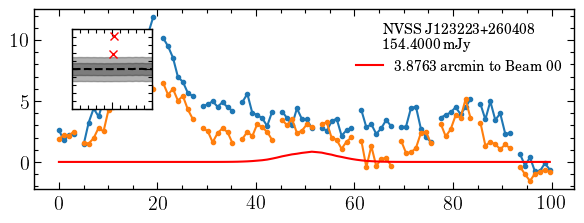

In [20]:
nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'
nvss_map_path = '/scratch3/users/ycli/fanalysis/nvss_map_th10_nside8192_beam.h5'
#file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC//'
file_name = '20210302/HIMGS_1100+2600'
file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
             for i in range(1, 8)]

check_flux(file_list, nvss_path, fwhm_path)

In [7]:
def output_radec(file_list, output_path):
    
    with h5py.File(output_path + 'ra_dec.h5', 'w') as f:
        for fi, files in enumerate(file_list):
            vis, time, freq, ra, dec = load_ts(files, freq_sel = slice(0, None))
            on = np.all(vis.mask, axis=(1, 2))
            f['ra_dec_%02d'%fi] = np.concatenate([ra[:, None, :], dec[:, None, :]], axis=1)
            f['mask_%02d'%fi] = on
            
        

In [7]:
file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
file_list = []
for file_name in  ['20210302/HIMGS_1100+2600', '20210313/HIMGS_1100+2621',
                   '20210309/HIMGS_1100+2610', '20210306/HIMGS_1100+2643',
                   '20210305/HIMGS_1100+2632', '20210307/HIMGS_1100+2654',
                   '20210314/HIMGS_1100+2610']:
    file_list.append([file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
                      for i in range(1, 8)])
    
#print file_list
output_path = '/idia/users/ycli/fdata/'
#output_radec(file_list, output_path)

In [8]:
with h5py.File('/idia/users/ycli/fdata/ra_dec.h5', 'r') as f:
    print f.keys()

[u'ra_dec_00', u'ra_dec_01', u'ra_dec_02', u'ra_dec_03', u'ra_dec_04', u'ra_dec_05', u'ra_dec_06']


In [8]:
from fpipe.pipeline.pipeline import run_pipeline
@run_pipeline
def correct_coord():
    
    data_base = '/scratch3/users/ycli/fanalysis/'
    
    pipe_tasks = []
    pipe_outdir = data_base
    pipe_logging = 'info'
    pipe_copy = False
    pipe_feedback = 0

    pipe_tasks.append(Correct_Coord)

    suffix = '_1250-1450MHz'
    #suffix = '_1050-1150MHz'
    
    coord_root = '/idia/users/ycli/fdata/coord/'   
    
    file_name = '20210314/HIMGS_1100+2610'
    coord_file = coord_root + 'HIMGS_1100+2610_2021_03_14_22_23_42_000.xlsx'
    
    #file_name = '20210313/HIMGS_1100+2621'
    #coord_file = coord_root + 'HIMGS_1100+2621_2021_03_13_22_27_38_000.xlsx'
    
    #file_name = '20210309/HIMGS_1100+2610'
    #coord_file = coord_root + 'HIMGS_1100+2610_2021_03_09_22_43_22_000.xlsx'
    
    #file_name = '20210306/HIMGS_1100+2643'
    #coord_file = coord_root + 'HIMGS_1100+2643_2021_03_06_22_55_09_000.xlsx'
    
    #file_name = '20210305/HIMGS_1100+2632'
    #coord_file = coord_root + 'HIMGS_1100+2632_2021_03_05_22_59_05_000.xlsx'
    
    #file_name = '20210307/HIMGS_1100+2654'
    #coord_file = coord_root + 'HIMGS_1100+2654_2021_03_07_22_51_13_000.xlsx'
    
    #file_name = '20210302/HIMGS_1100+2600'
    #coord_file = coord_root + 'HIMGS_1100+2600_2021_03_02_23_10_53_000.xlsx'
    
    file_list = ['%s_arcdrift%04d-%04d%s.h5'%(file_name, i, i, suffix) 
                 for i in range(1, 8)]
    
    cc_coord_file = coord_file
    #cc_input_files = ['rb4_rmbsl_sumfeeds/%s'%f for f in file_list]
    #cc_output_files = ['rb4_rmbsl_sumfeeds_CC/%s'%f for f in file_list]
    cc_input_files = ['rb4_etaA_sumfeeds//%s'%f for f in file_list]
    cc_output_files = ['rb4_etaA_sumfeeds/_CC/%s'%f for f in file_list]

    return locals()


correct_coord()

1384.296 1414.7849


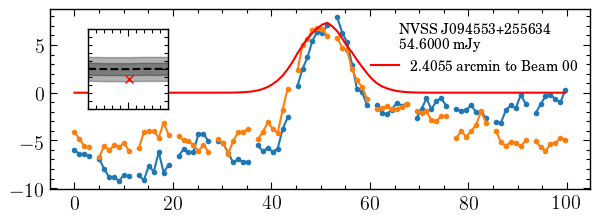

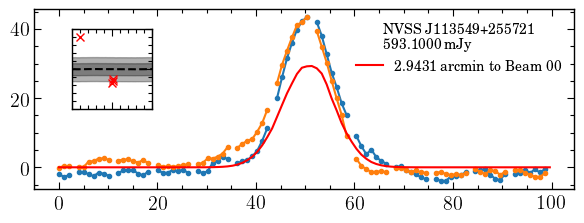

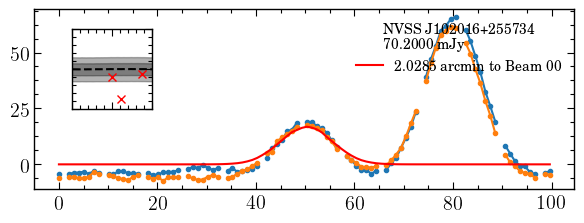

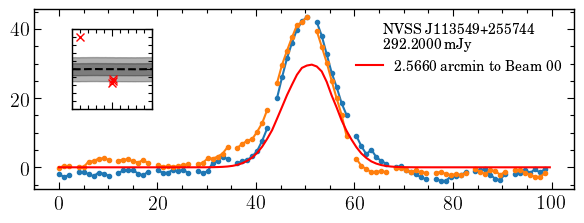

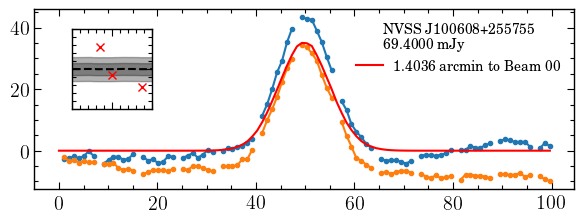

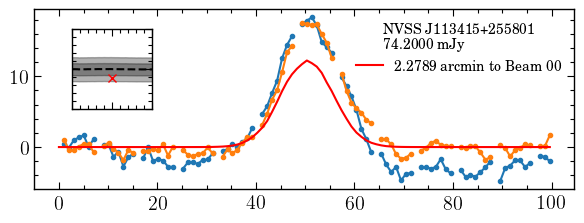

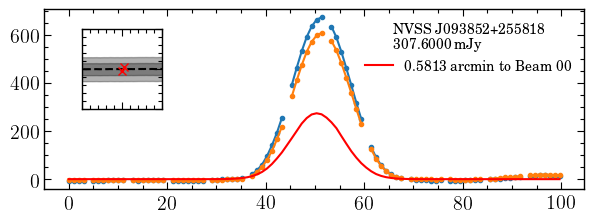

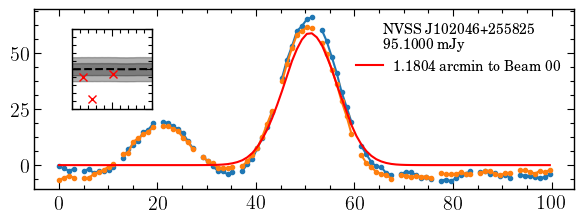

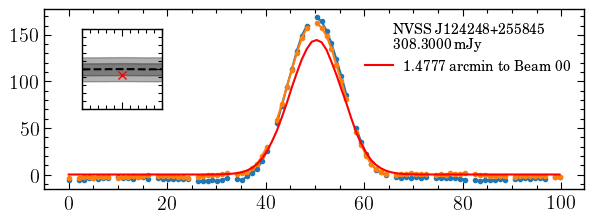

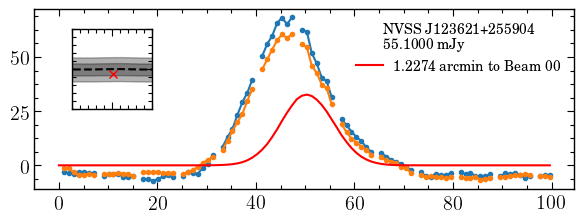

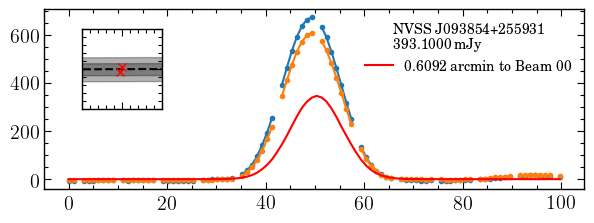

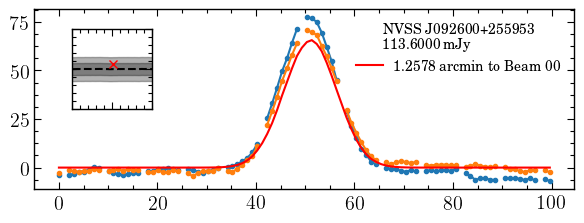

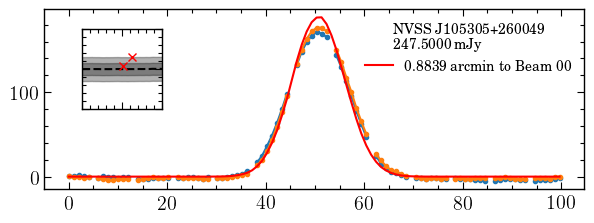

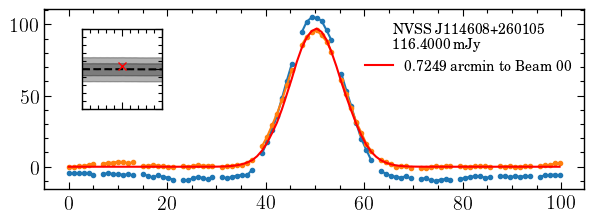

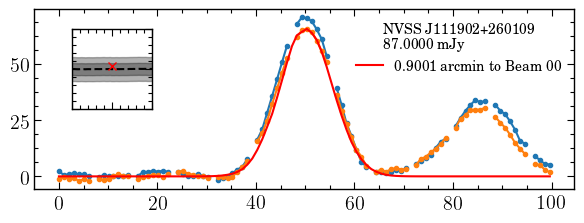

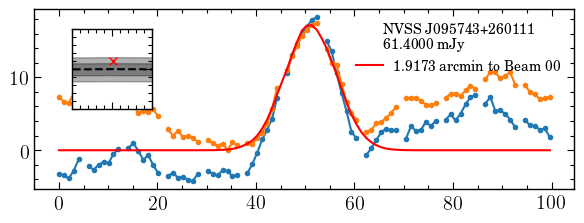

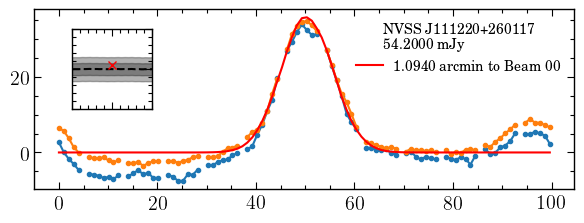

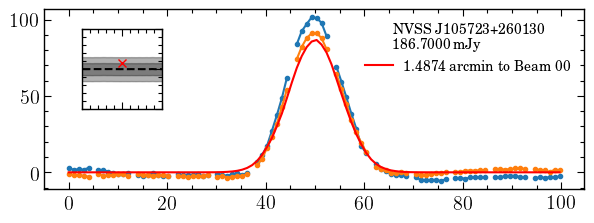

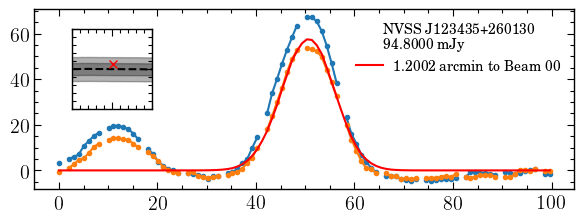

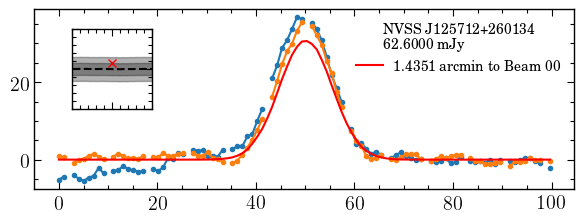

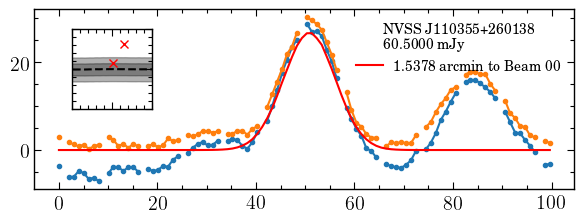

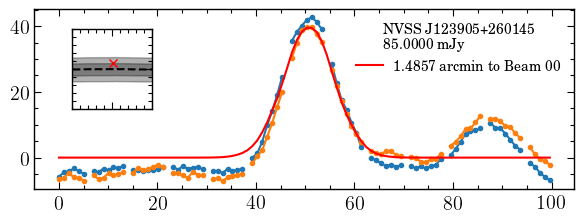

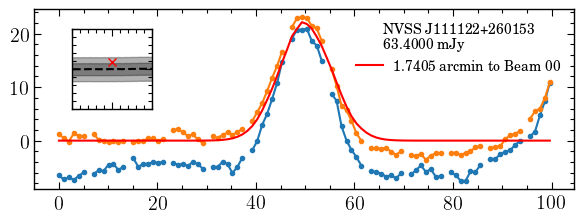

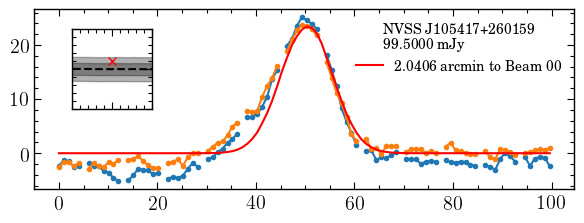

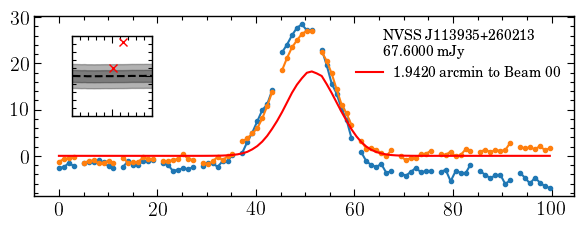

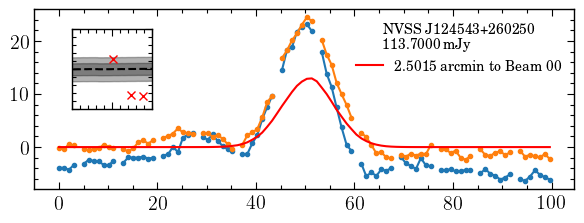

In [53]:
nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'
file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
file_name = '20210302/HIMGS_1100+2600'
file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
             for i in range(1, 8)]
check_flux(file_list, nvss_path, fwhm_path)

1384.296 1414.7849


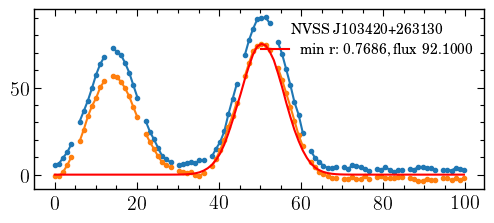

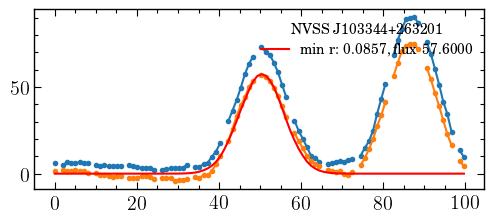

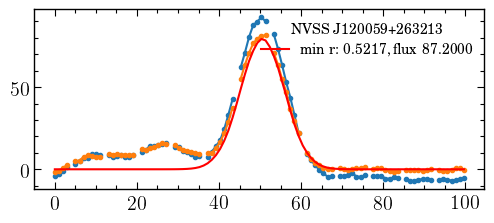

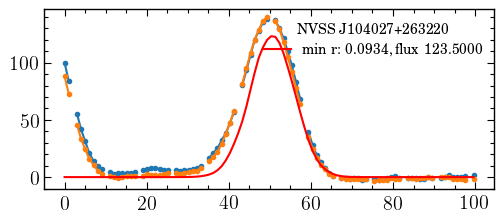

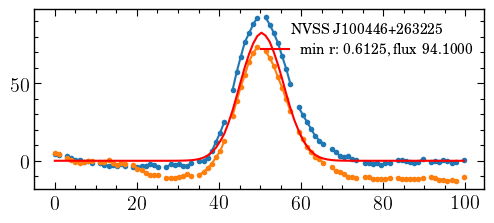

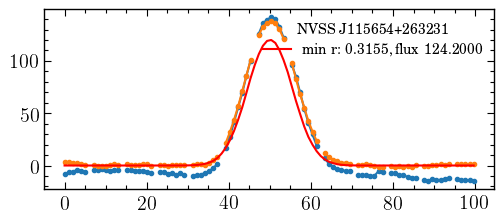

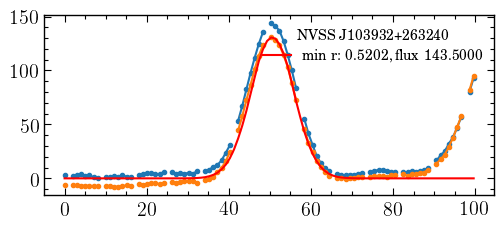

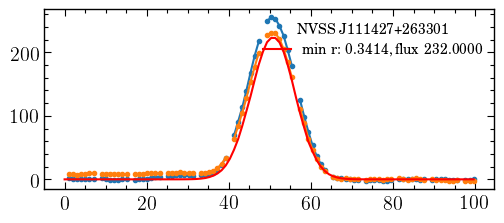

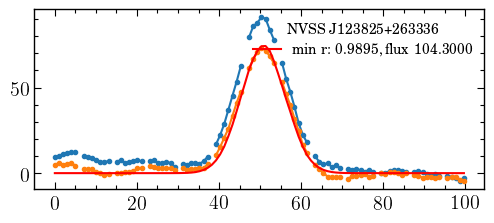

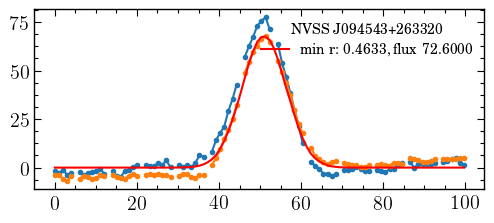

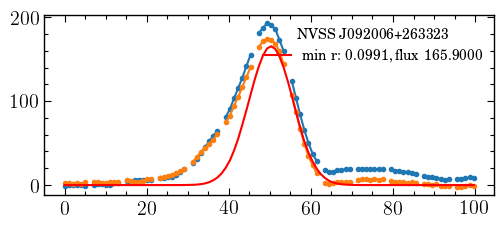

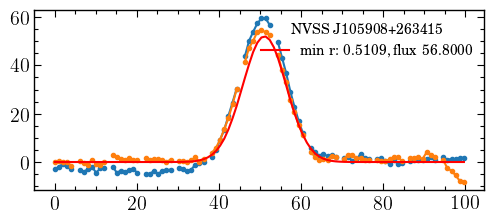

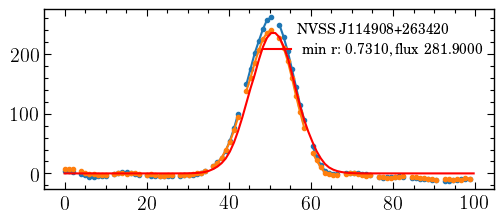

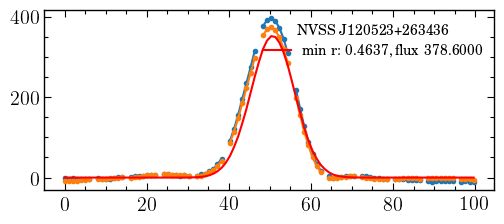

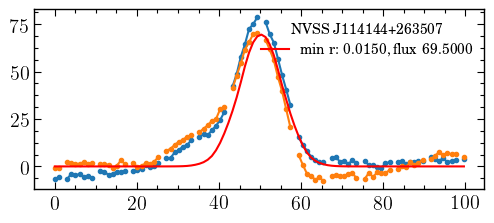

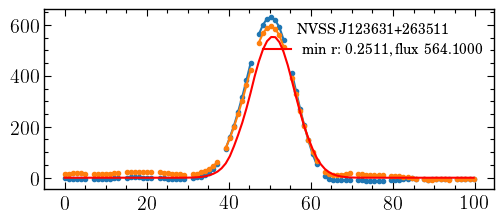

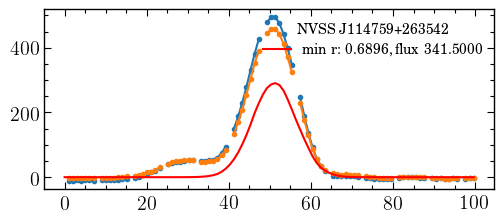

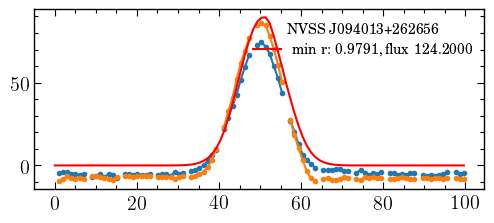

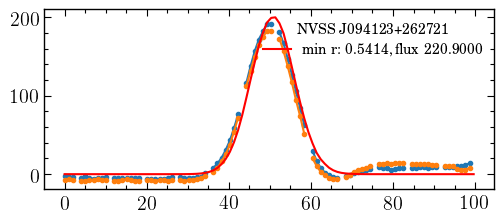

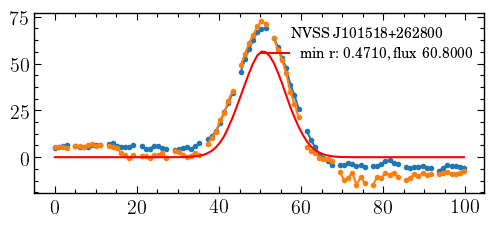

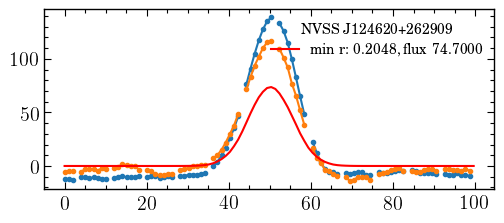

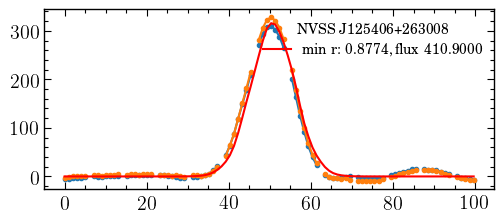

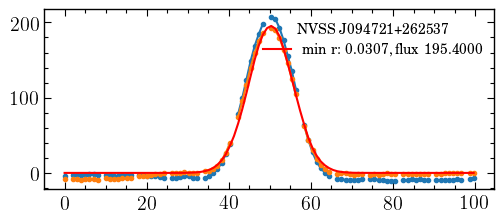

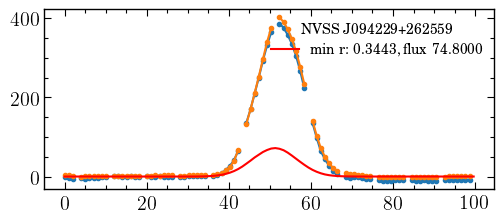

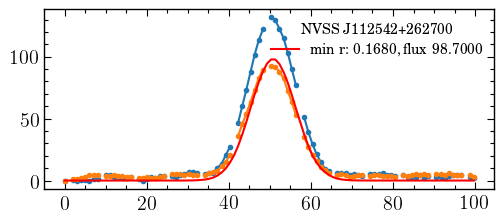

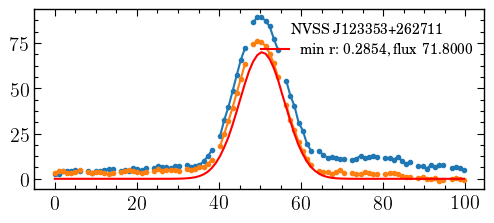

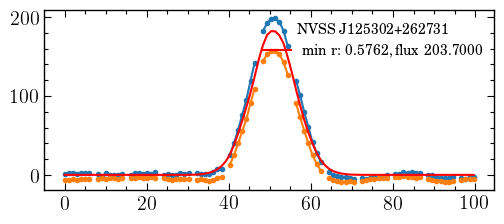

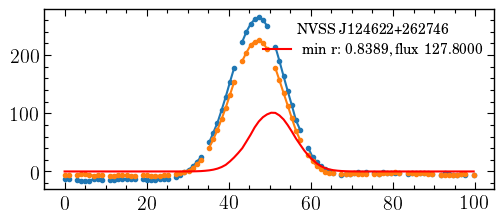

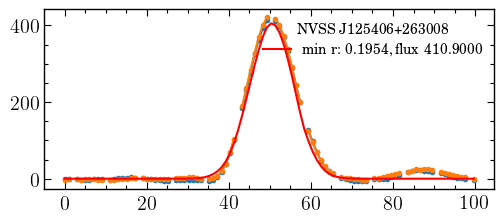

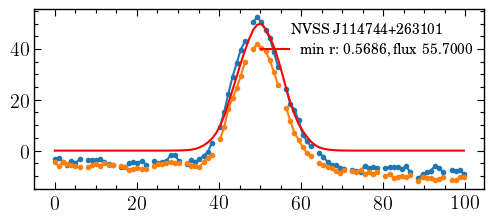

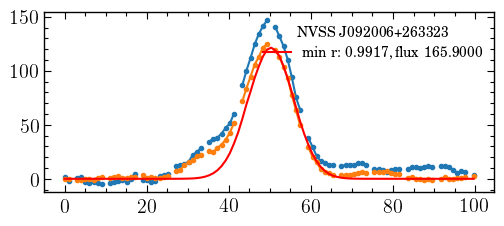

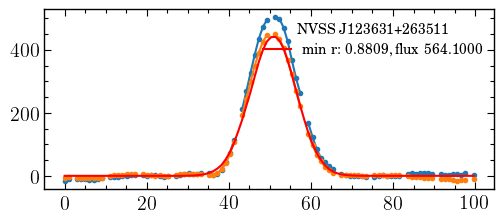

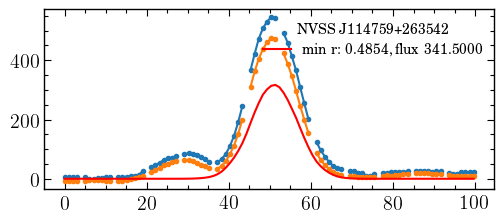

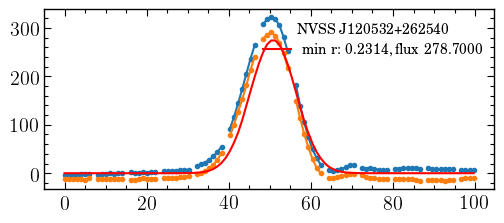

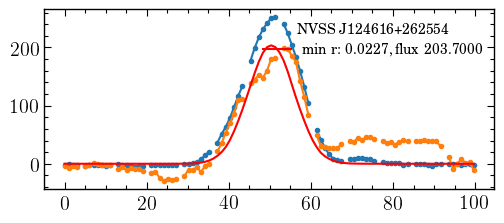

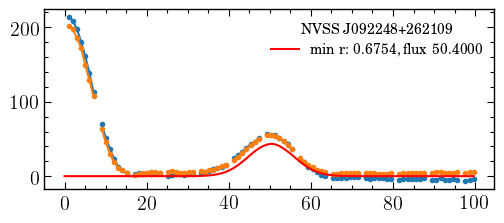

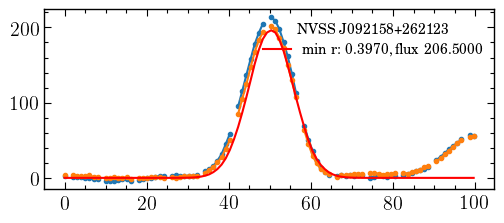

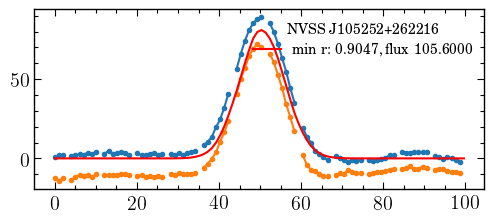

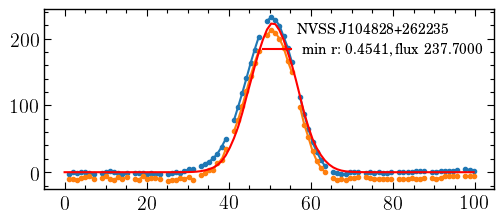

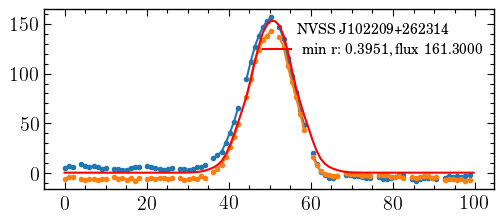

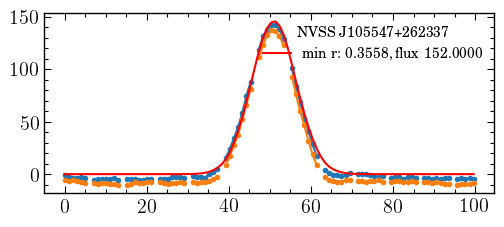

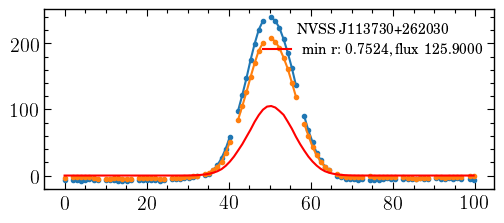

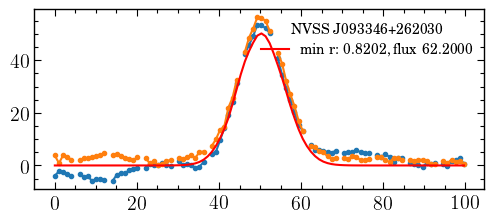

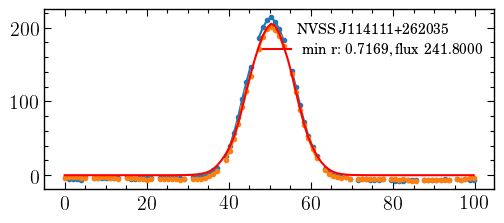

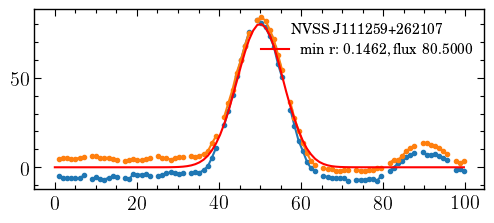

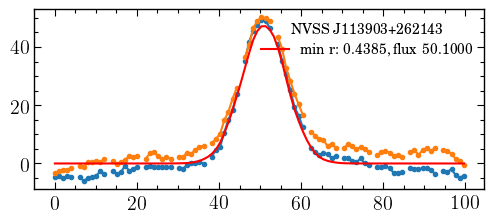

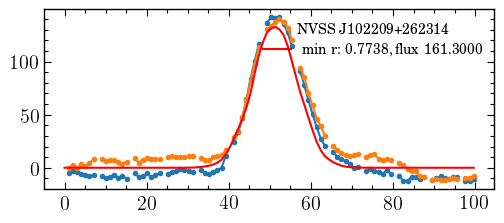

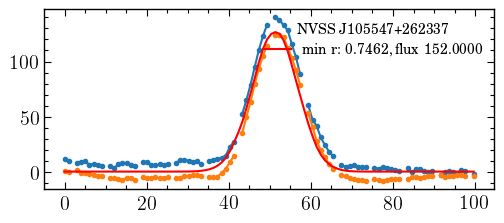

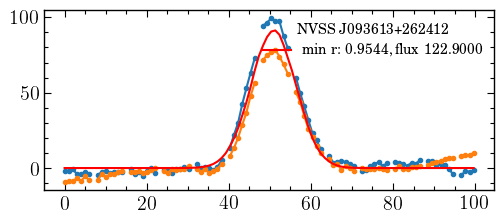

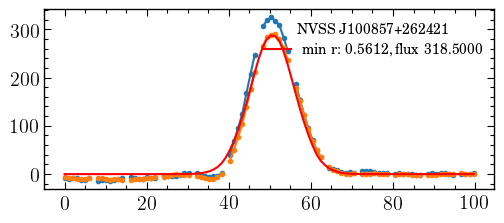

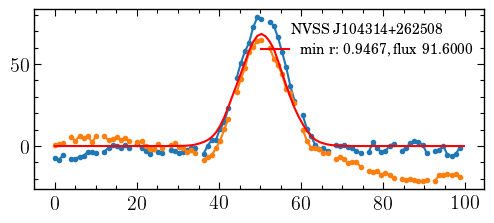

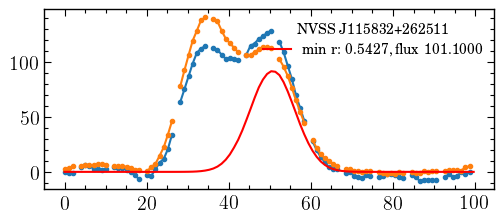

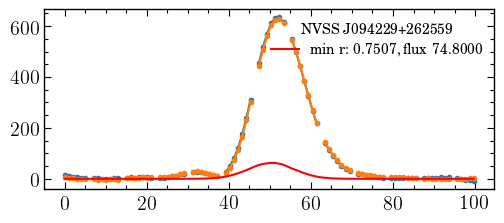

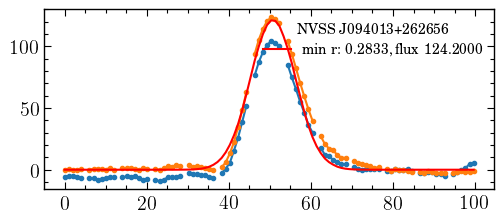

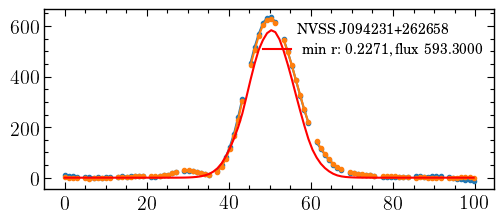

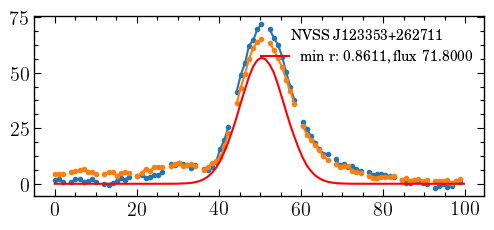

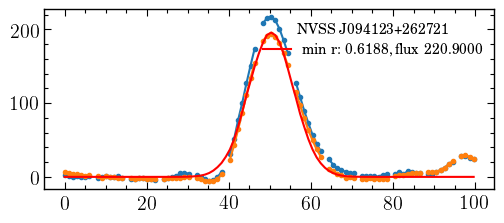

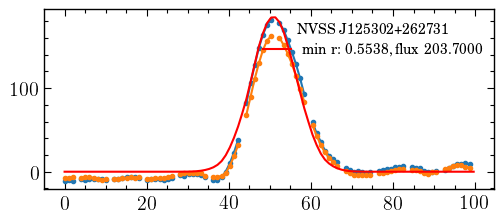

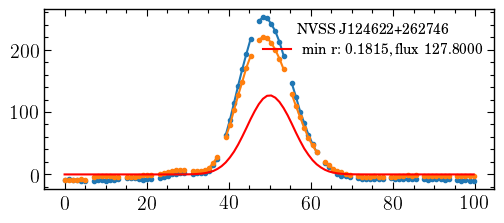

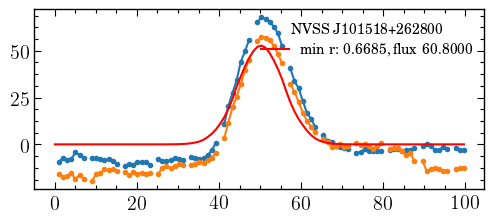

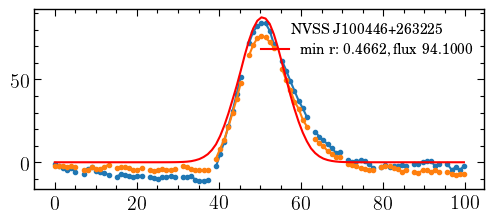

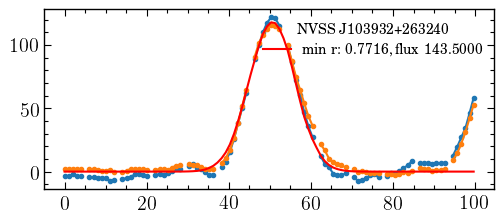

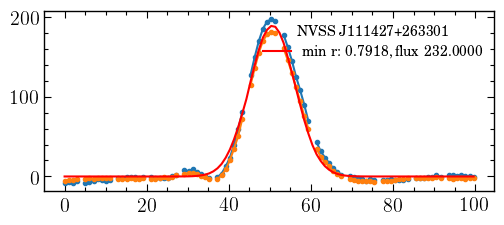

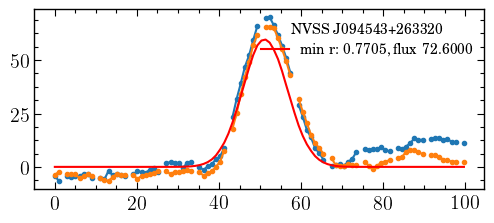

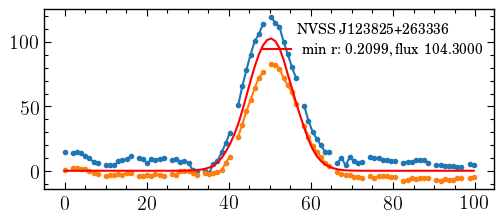

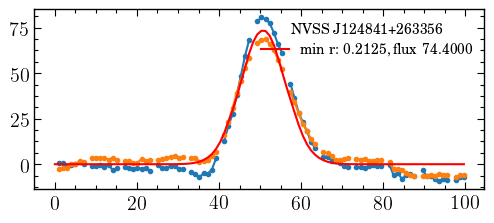

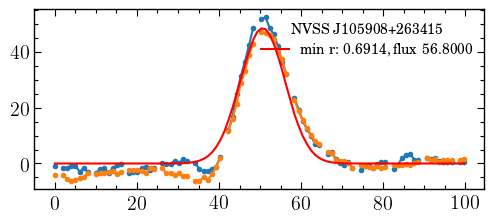

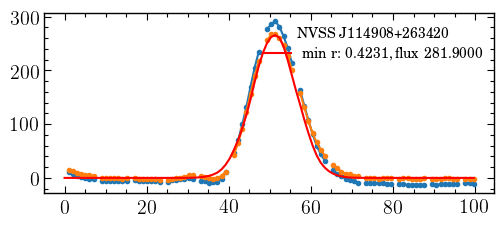

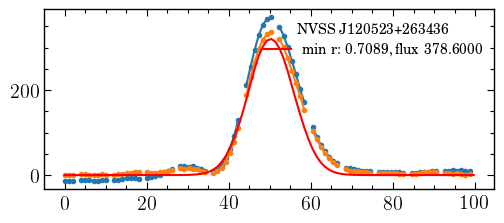

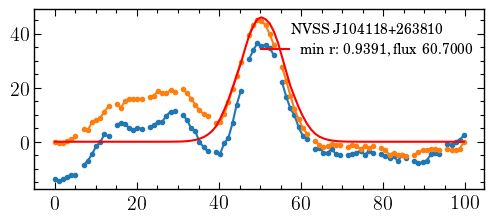

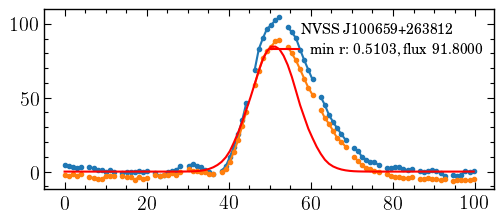

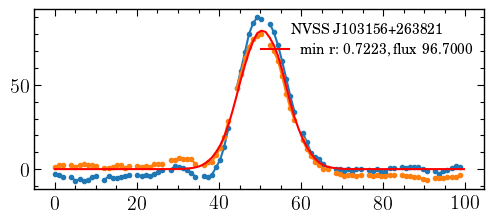

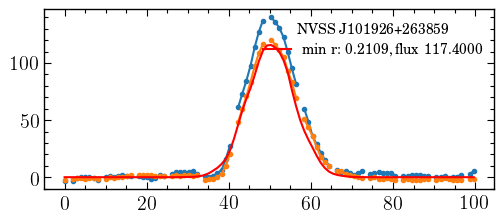

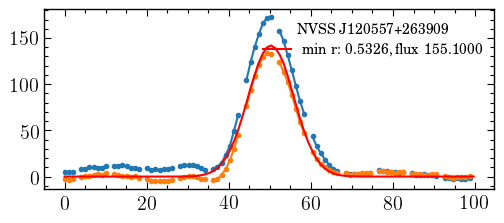

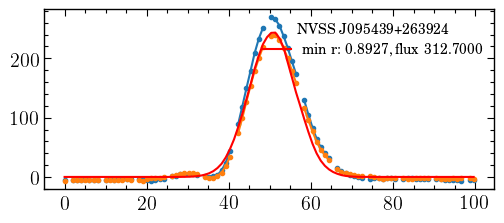

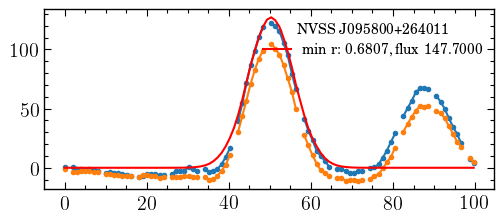

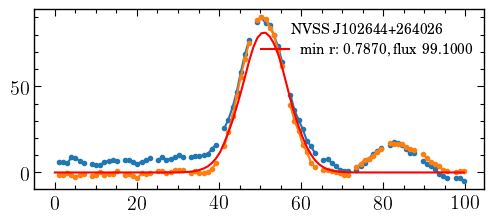

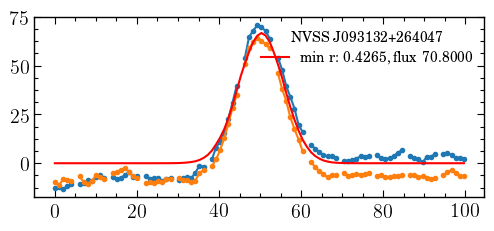

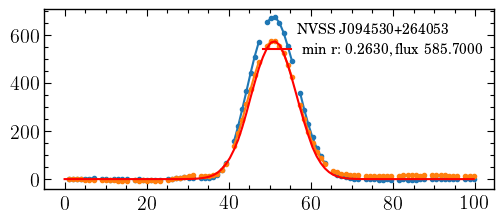

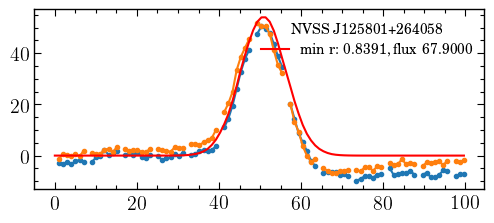

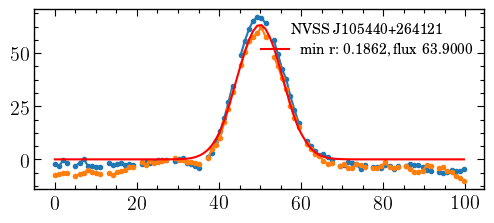

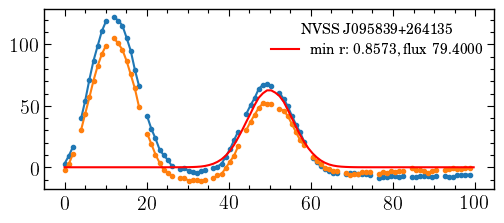

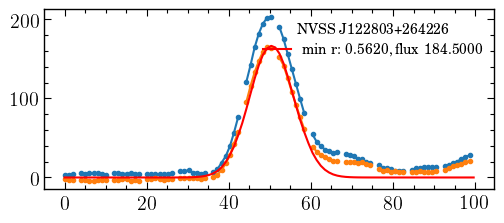

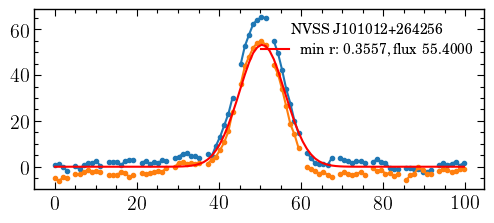

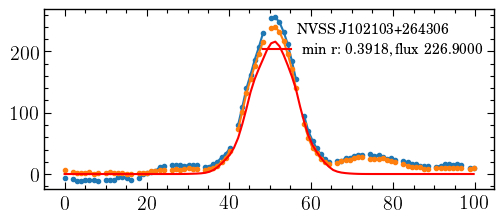

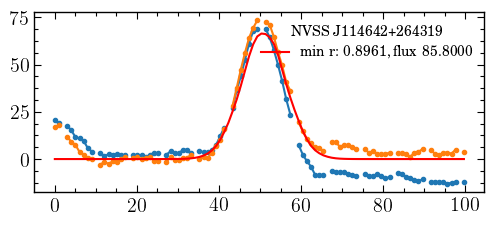

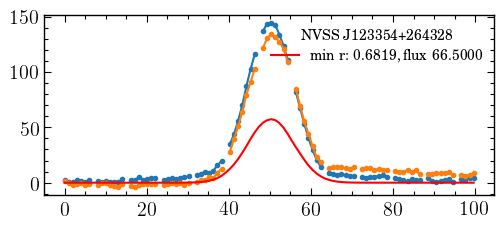

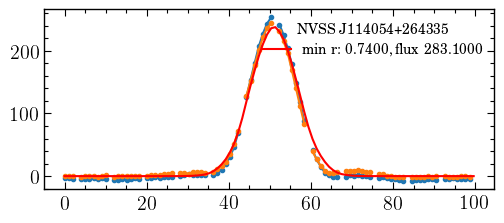

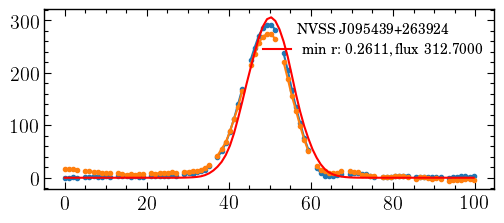

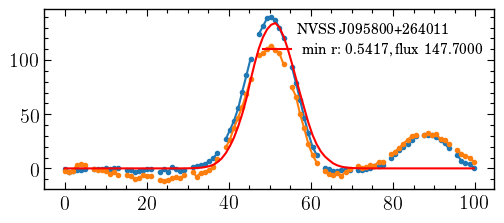

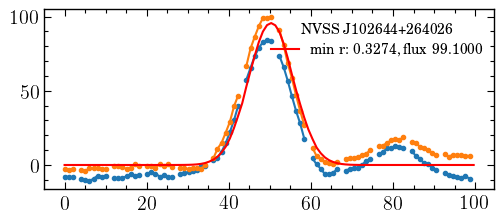

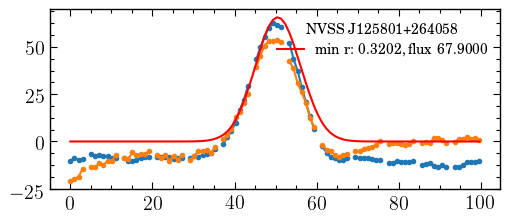

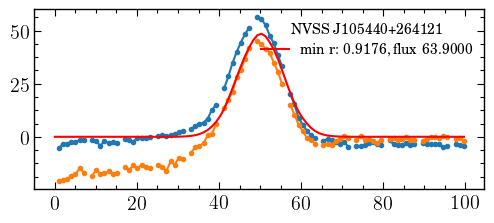

In [40]:
nvss_path = '/idia/users/ycli/NVSS/nvss_N25-N27.fits'
fwhm_path = '/users/ycli/code/fpipe/fpipe/data/fwhm.dat'
file_root = '/scratch3/users/ycli/fanalysis/rb4_sumfeeds_CorrectCoord/'
file_name = '20210305/HIMGS_1100+2632'
file_list = [file_root + '%s_arcdrift%04d-%04d_1250-1450MHz.h5'%(file_name, i, i) 
             for i in range(1, 8)]
check_flux(file_list, nvss_path, fwhm_path)

In [11]:
coord_path = '/idia/users/ycli/fdata/coord/'
#coord_file = 'HIMGS_1100+2654_2021_03_07_22_51_13_000.xlsx'
coord_file = 'HIMGS_1100+2600_2021_03_02_23_10_53_000.xlsx'
time_coord, az_coord, alt_coord = coord.xyz2azalt(coord_path + coord_file)

read ant. coord SwtDPos_X SwtDPos_Y SwtDPos_Z


In [17]:
#az = np.median(az_coord) * np.ones(time_coord.shape)
#alt= np.median(alt_coord) * np.ones(time_coord.shape)
az = az_coord.copy()
alt= alt_coord.copy()


az_f  = interp1d(time_coord.unix, az , kind='nearest', 
                 bounds_error=False, fill_value="extrapolate")
alt_f = interp1d(time_coord.unix, alt, kind='nearest', 
                 bounds_error=False, fill_value="extrapolate")

#print time.unix
alt0 = alt_f(time)
az0 = az_f(time)
az, alt, ra_new, dec_new = coord.get_pointing_any_scan(time, alt0, az0, 
                                                       time_format='unix', 
                                                       feed_rotation=23.4)

In [24]:
print ra[:10, 0]
print ra_new[:10, 0]

[134.89792489 134.90255523 134.90680594 134.91096245 134.91494596
 134.91862848 134.92274045 134.9269997  134.9316167  134.93582403]
[134.89792489 134.90255523 134.90680594 134.91096245 134.91494596
 134.91862848 134.92274045 134.9269997  134.9316167  134.93582403]
